## Capstone Project Submission

* Student name: Kiarash Ahmadi
* Student pace: self-paced
* Scheduled project review date/time: 07/15/2021
* Instructor name: Jeff Herman

# Introduction:

My capstone project focuses on unvealing the blackbox behind ESPN's Real Plus-Minus statistic, an advanced NBA stat that measures the impact a player has on the court. This [statistic](https://www.espn.com/nba/story/_/id/10740818/introducing-real-plus-minus) was introduced in 2014 as a more advanced way to analyze player impact rather than the infamous plus-minus. The metric seperates itself from this conventional statistic as it "isolates the unique plus-minus impact of each NBA player by adjusting for the effects of each teammate and opposing player". There has been [extensive discussion](https://cornerthreehoops.wordpress.com/2014/04/17/explaining-espns-real-plus-minus/) on the process behind the calculation of this metric. Therefore, I felt that there is a need to understand what conventional statistics affect RPM and how accurately can I predict RPM using these convetional statistics. The framework behind developing models involved following the OSEMiN Data Science Process. This process consists of 5 key steps: 
* Obtain: 
    * Extracting the data 
* Scrub: 
    * Preprocessing the data for the model 
    * Examples include normalizing the data, removing or replacing null values, or dealing with outliers
* Explore: 
    * This step tends to blend in with the "Scrub" step 
    * Visualize and explore the data to have an understanding of how to prepare the predictors and whether any can be dropped in order to have more accurate model
    * Analyzing the dataset for patterns when it comes to certain predictors and their correlation with RPM
* Model: 
    * The data is then modeled via various modeling techniques and types in order to minimize the error
    * This process may consist of some data scrubbing in order to achieve better results. 
* Interpret: 
    * The results of the model are interpreted and echoed to stakeholders.

Thus, let's begin this exciting process!

# Imports 

First, let's import the necessary packages for this project.

In [1]:
import unidecode
from difflib import SequenceMatcher
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import shap
from IPython import display

# Obtaining Data

Let's extract the data by using pandas and it's read_html function. We will first obtain conventional statistics from basketball-reference.com using pandas and its read_html function.  

In [4]:
df_stats = pd.read_html('https://www.basketball-reference.com/leagues/NBA_2021_per_game.html')[0]
df_stats

Rk             Player Pos Age   Tm   G  ...  AST  STL  BLK  TOV   PF   PTS
0      1   Precious Achiuwa  PF  21  MIA  61  ...  0.5  0.3  0.5  0.7  1.5   5.0
1      2       Jaylen Adams  PG  24  MIL   7  ...  0.3  0.0  0.0  0.0  0.1   0.3
2      3       Steven Adams   C  27  NOP  58  ...  1.9  0.9  0.7  1.3  1.9   7.6
3      4        Bam Adebayo   C  23  MIA  64  ...  5.4  1.2  1.0  2.6  2.3  18.7
4      5  LaMarcus Aldridge   C  35  TOT  26  ...  1.9  0.4  1.1  1.0  1.8  13.5
..   ...                ...  ..  ..  ...  ..  ...  ...  ...  ...  ...  ...   ...
726  536       Delon Wright  PG  28  SAC  27  ...  3.6  1.6  0.4  1.3  1.1  10.0
727  537     Thaddeus Young  PF  32  CHI  68  ...  4.3  1.1  0.6  2.0  2.2  12.1
728  538         Trae Young  PG  22  ATL  63  ...  9.4  0.8  0.2  4.1  1.8  25.3
729  539        Cody Zeller   C  28  CHO  48  ...  1.8  0.6  0.4  1.1  2.5   9.4
730  540        Ivica Zubac   C  23  LAC  72  ...  1.3  0.3  0.9  1.1  2.6   9.0

[731 rows x 30 columns]

Let's  next extract ESPN's RPM data by using the same method as before and accessing their website.

In [5]:
frame = []
for i in range(1,15):
  # first page has a different notation than the others
    if i == 1:
        temp = pd.read_html('http://www.espn.com/nba/statistics/rpm/_/sort/RPM')[0]

    else:
        link = 'http://www.espn.com/nba/statistics/rpm/_/page/' + str(i)
        temp = pd.read_html(link)[0] 
    temp.columns = temp.iloc[0]
    temp = temp[1:]
    frame.append(temp)
df_rpm = pd.concat(frame)
df_rpm.reset_index(drop=True)
df_rpm.head(50)

0   RK                       NAME     TEAM  GP   MPG   ORPM   DRPM   RPM   WINS
1    1          Stephen Curry, PG       GS  63  34.2   7.08   0.10  7.18  19.05
2    2           LeBron James, SF      LAL  45  33.4   4.63   2.10  6.73  11.91
3    3             Rudy Gobert, C     UTAH  71  30.8  -1.45   8.00  6.55  16.52
4    4            Paul George, SG      LAC  54  33.7   1.55   3.89  5.45  11.98
5    5  Giannis Antetokounmpo, PF      MIL  61  33.0   3.89   1.20  5.09  14.03
6    6            Nikola Jokic, C      DEN  72  34.6   3.12   1.96  5.08  15.85
7    7             Joel Embiid, C      PHI  51  31.1   2.04   2.98  5.02  10.01
8    8           James Harden, SG  HOU/BKN  44  36.6   3.99   0.98  4.97   9.94
9    9         Damian Lillard, PG      POR  67  35.8   3.88   1.09  4.97  14.55
10  10             Lonzo Ball, PG       NO  55  31.8   3.19   1.27  4.46  10.06
11  11            Mike Conley, PG     UTAH  51  29.4   1.25   3.12  4.37   8.28
12  12          Fred VanVleet, SG      TOR  52  36.5   1.27   2.78  4.05  10.67
13  13             Kyle Lowry, PG      TOR  46  34.8   2.90   1.12  4.02   8.98
14  14           Kevin Durant, PF      BKN  35  33.1   4.07  -0.11  3.95   6.06
15  15        Devonte' Graham, PG      CHA  55  30.2   1.92   1.97  3.88   9.24
16  16            CJ McCollum, SG      POR  47  34.0   2.09   1.78  3.87   8.42
17  17            Ben Simmons, PG      PHI  58  32.4   1.28   2.39  3.67   9.80
18  18             Chris Paul, PG      PHX  70  31.4   0.48   3.06  3.54  10.78
19  19           Jamal Murray, PG      DEN  48  35.5   0.41   3.07  3.48   8.04
20  20           Kyrie Irving, PG      BKN  54  34.9   2.96   0.49  3.44   9.16
21  21           Jimmy Butler, SF      MIA  52  33.6   1.50   1.90  3.40   8.70
22  22          Julius Randle, PF       NY  71  37.6  -0.76   4.16  3.40  12.36
23  23             Joe Harris, SF      BKN  69  31.0  -0.60   4.00  3.40  10.14
24  24            Clint Capela, C      ATL  63  30.1  -1.63   4.98  3.35   9.12
25  25        Zion Williamson, PF       NO  61  33.2   1.07   2.13  3.20   9.45
26  26          Christian Wood, C      HOU  41  32.3   0.54   2.60  3.14   6.19
27  27             Bam Adebayo, C      MIA  64  33.5  -0.77   3.78  3.01   9.56
28  28            Luka Doncic, PG      DAL  66  34.3   2.44   0.51  2.96  10.37
29  29        Duncan Robinson, SG      MIA  72  31.4  -0.56   3.45  2.89  10.04
30  30           Terry Rozier, SG      CHA  69  34.5   1.29   1.59  2.88  10.77
31  31           Jaylen Brown, SG      BOS  58  34.5   2.10   0.71  2.81   9.39
32  32            Danny Green, SF      PHI  69  28.0  -0.87   3.67  2.80   8.28
33  33           De'Aaron Fox, PG      SAC  58  35.1   2.92  -0.27  2.66   8.85
34  34          Kyle Anderson, SF      MEM  69  27.3   0.16   2.44  2.60   7.82
35  35           Jrue Holiday, PG      MIL  59  32.3   1.80   0.77  2.57   8.64
36  36          Kawhi Leonard, SF      LAC  52  34.1   1.46   1.10  2.55   7.55
37  37       Donovan Mitchell, SG     UTAH  53  33.4   3.26  -0.76  2.50   7.52
38  38            Zach LaVine, SG      CHI  58  35.1   1.82   0.65  2.47   8.78
39  39          Tobias Harris, PF      PHI  62  32.5  -0.20   2.65  2.45   8.21
40  40           Jayson Tatum, SF      BOS  64  35.8   1.06   1.39  2.44   9.60
1   41       Donte DiVincenzo, SG      MIL  66  27.5   0.66   1.71  2.36   7.57
2   42      Bogdan Bogdanovic, SG      ATL  44  29.7   2.16   0.14  2.30   5.62
3   43            Buddy Hield, SG      SAC  71  34.3   0.60   1.66  2.26   9.38
4   44           Devin Booker, SG      PHX  67  33.9   1.02   1.21  2.23   8.72
5   45             Trae Young, PG      ATL  63  33.7   2.36  -0.14  2.22   8.16
6   46          Mikal Bridges, SF      PHX  72  32.6  -0.36   2.56  2.21   8.98
7   47       Jonas Valanciunas, C      MEM  62  28.3  -0.49   2.68  2.19   6.62
8   48           John Collins, PF      ATL  63  29.3  -0.14   2.28  2.15   6.92
9   49      Russell Westbrook, PG      WSH  65  36.4   1.99   0.05  2.03   8.98


We now have to begin the process of joining these two DataFrames. The only way to join these two datasets is via name. It looks like the RPM dataset's names also include their positions. Let's get rid of positions in the "NAME" column in hopes to join the two datasets after.


In [6]:
names = {}
for name in df_rpm.NAME:
  where = name.find(',')
  new_name = name[:where]
  names[name] = new_name

In [7]:
df_rpm.NAME.replace(names, inplace = True)
df_rpm

0    RK                   NAME     TEAM  GP   MPG   ORPM   DRPM    RPM   WINS
1     1          Stephen Curry       GS  63  34.2   7.08   0.10   7.18  19.05
2     2           LeBron James      LAL  45  33.4   4.63   2.10   6.73  11.91
3     3            Rudy Gobert     UTAH  71  30.8  -1.45   8.00   6.55  16.52
4     4            Paul George      LAC  54  33.7   1.55   3.89   5.45  11.98
5     5  Giannis Antetokounmpo      MIL  61  33.0   3.89   1.20   5.09  14.03
..  ...                    ...      ...  ..   ...    ...    ...    ...    ...
10  530            P.J. Tucker  HOU/MIL  52  26.1  -3.40  -0.70  -4.11  -2.85
11  531         Romeo Langford      BOS  18  15.7  -2.62  -1.72  -4.34  -0.61
12  532            Noah Vonleh      BKN   4   2.8  -3.91  -0.47  -4.38  -0.01
13  533            Rodney Hood  POR/TOR  55  17.1  -2.81  -1.74  -4.55  -2.34
14  534            Malik Fitts      LAC   3   3.7  -2.43  -2.12  -4.55  -0.02

[534 rows x 9 columns]

It looks like the basketball reference dataset has players names show up mulitple times if they have been different teams. For example, LaMarcus Alridge shows up 3 times in the dataset: once with the stats he accumulated in San Antonio, once with the stats he accumulated in Brooklyn, and once for the total stats. Let's address this by removing rows of players who have been on multiple teams and only keeping their total stats. 

In [8]:
count_freq = dict(df_stats['Player'].value_counts())
df_stats['count_freq'] = df_stats.Player
df_stats['count_freq'] = df_stats['count_freq'].map(count_freq)

In [ ]:
df_filtered = df_stats.loc[((df_stats.count_freq > 1) & (df_stats.Tm == 'TOT')) | (df_stats.count_freq == 1),:].copy()
df_filtered.head()

Rk             Player Pos Age   Tm   G  GS    MP   FG   FGA  ...  ORB  DRB  \
0  1   Precious Achiuwa  PF  21  MIA  61   4  12.1  2.0   3.7  ...  1.2  2.2   
1  2       Jaylen Adams  PG  24  MIL   7   0   2.6  0.1   1.1  ...  0.0  0.4   
2  3       Steven Adams   C  27  NOP  58  58  27.7  3.3   5.3  ...  3.7  5.2   
3  4        Bam Adebayo   C  23  MIA  64  64  33.5  7.1  12.5  ...  2.2  6.7   
4  5  LaMarcus Aldridge   C  35  TOT  26  23  25.9  5.4  11.4  ...  0.7  3.8   

   TRB  AST  STL  BLK  TOV   PF   PTS count_freq  
0  3.4  0.5  0.3  0.5  0.7  1.5   5.0          1  
1  0.4  0.3  0.0  0.0  0.0  0.1   0.3          1  
2  8.9  1.9  0.9  0.7  1.3  1.9   7.6          1  
3  9.0  5.4  1.2  1.0  2.6  2.3  18.7          1  
4  4.5  1.9  0.4  1.1  1.0  1.8  13.5          3  

[5 rows x 31 columns]

We now have altered the datasets enough to where they are ready to be joined. Let's first check the number of rows in each dataset.

In [ ]:
df_filtered.shape

(540, 31)

In [ ]:
df_rpm.shape

(534, 9)

It looks like the datasets have different lengths. This is somewhat expected and there might a chance that some rows will not be part of the merging process. However, let's make sure there aren't too many differences with the datasets by checking for names that are in one dataset and not the other and vice versa. Let's first check for names that in the RPM dataset but not in the conventional dataset. 

In [ ]:
rpm = list(df_rpm.NAME)
stats = list(df_filtered.Player)
rpm_names = np.setdiff1d(rpm, stats)

In [ ]:
np.setdiff1d(rpm, stats)

array(['Alen Smailagic', 'Anderson Varejao', 'Boban Marjanovic',
       'Bogdan Bogdanovic', 'Bojan Bogdanovic', 'Brian Bowen II',
       'Charles Brown Jr.', 'Charlie Brown Jr.', 'Cristiano Felicio',
       'Danuel House Jr.', 'Dario Saric', 'Davis Bertans',
       'Dennis Schroder', 'Ersan Ilyasova', 'Goran Dragic',
       'Harry Giles III', 'JJ Redick', 'James Ennis III',
       'Jonas Valanciunas', 'Juancho Hernangomez', 'Jusuf Nurkic',
       'Karim Mane', 'Kevin Knox II', 'Kristaps Porzingis',
       'Lonnie Walker IV', 'Luka Doncic', 'Luka Samanic',
       'Marcus Morris Sr.', 'Nicolo Melli', 'Nikola Jokic',
       'Nikola Vucevic', 'Otto Porter Jr.', 'Robert Williams III',
       'Robert Woodard II', 'Svi Mykhailiuk', 'Theo Maledon',
       'Timothe Luwawu-Cabarrot', 'Tomas Satoransky', 'Vlatko Cancar',
       'Wes Iwundu', 'Willy Hernangomez', 'Xavier Tillman'], dtype='<U24')

Before we make any judgements on these results, let's check for names that are in the conventional stats dataset and not in the RPM dataset. 

In [ ]:
np.setdiff1d(stats, rpm)

array(['Alen Smailagić', 'Anderson Varejão', 'Anžejs Pasečņiks',
       'Ashton Hagans', 'Boban Marjanović', 'Bogdan Bogdanović',
       'Bojan Bogdanović', 'Brian Bowen', 'Cameron Reynolds',
       'Charlie Brown', 'Cristiano Felício', 'Danuel House',
       'Dario Šarić', 'Dennis Schröder', 'Dāvis Bertāns', 'Elijah Bryant',
       'Ersan İlyasova', 'Goran Dragić', 'Harry Giles', 'J.J. Redick',
       'James Ennis', 'Jared Harper', 'Jonas Valančiūnas',
       'Juan Hernangómez', 'Jusuf Nurkić', 'Karim Mané', 'Kevin Knox',
       'Kristaps Porziņģis', 'Lonnie Walker', 'Luka Dončić',
       'Luka Šamanić', 'Marcus Morris', 'Nicolò Melli', 'Nikola Jokić',
       'Nikola Vučević', 'Otto Porter', 'Robert Williams',
       'Robert Woodard', 'Sviatoslav Mykhailiuk', 'Théo Maledon',
       'Timothé Luwawu-Cabarrot', 'Tomáš Satoranský', 'Udonis Haslem',
       'Vlatko Čančar', 'Wesley Iwundu', 'Will Magnay',
       'Willy Hernangómez', 'Xavier Tillman Sr.'], dtype='<U24')

It looks like the RPM dataset has no accent marks on players' names where as the conventional stats dataset does. Let's try to address this by getting rid of the accent marks in all the names in the conventional dataset. This will be done by using a package called unidecode that simply strips accent marks from a string. 

In [ ]:
stats_names = np.setdiff1d(stats, rpm)

In [ ]:
names_dict = {}
for name in df_filtered.Player:
  new_name = unidecode.unidecode(name)
  names_dict[name] = new_name
df_filtered.Player.replace(names_dict, inplace = True)

We have gotten rid of accent marks on all the names within the dataset. Let's next check the differences in names between the two datasets again to see if we are ready for merging. 

In [ ]:
rpm = list(df_rpm.NAME)
stats = list(df_filtered.Player)
np.setdiff1d(rpm, stats)

array(['Brian Bowen II', 'Charles Brown Jr.', 'Charlie Brown Jr.',
       'Danuel House Jr.', 'Harry Giles III', 'JJ Redick',
       'James Ennis III', 'Juancho Hernangomez', 'Kevin Knox II',
       'Lonnie Walker IV', 'Marcus Morris Sr.', 'Otto Porter Jr.',
       'Robert Williams III', 'Robert Woodard II', 'Svi Mykhailiuk',
       'Wes Iwundu', 'Xavier Tillman'], dtype='<U24')

In [ ]:
np.setdiff1d(stats, rpm)

array(['Anzejs Pasecniks', 'Ashton Hagans', 'Brian Bowen',
       'Cameron Reynolds', 'Charlie Brown', 'Danuel House',
       'Elijah Bryant', 'Harry Giles', 'J.J. Redick', 'James Ennis',
       'Jared Harper', 'Juan Hernangomez', 'Kevin Knox', 'Lonnie Walker',
       'Marcus Morris', 'Otto Porter', 'Robert Williams',
       'Robert Woodard', 'Sviatoslav Mykhailiuk', 'Udonis Haslem',
       'Wesley Iwundu', 'Will Magnay', 'Xavier Tillman Sr.'], dtype='<U24')

It looks like there are suffixes in some players' names and there is inconsistency among the two datasets. Thus, let's fix this by stripping all the suffixes off the names. 

In [ ]:
name_list = []
for name in df_rpm.NAME:
  spaces = [pos for pos, char in enumerate(name) if char == ' ']
  if len(spaces) > 1:
    new_name = name[:spaces[-1]]
  else:
    new_name = name
  name_list.append(new_name)

In [ ]:
df_rpm.NAME = name_list

In [ ]:
name_list = []
for name in df_filtered.Player:
  spaces = [pos for pos, char in enumerate(name) if char == ' ']
  if len(spaces) > 1:
    new_name = name[:spaces[-1]]
  else:
    new_name = name
  name_list.append(new_name)

In [ ]:
df_filtered.Player = name_list

Once again, we will see each the differences between the two datasets to see if it is ready for merging. 

In [ ]:
rpm = list(df_rpm.NAME)
stats = list(df_filtered.Player)
rpm_names = np.setdiff1d(rpm, stats)
stats_names = np.setdiff1d(stats, rpm)

In [ ]:
np.setdiff1d(rpm, stats)

array(['Charles Brown', 'JJ Redick', 'Juancho Hernangomez',
       'Svi Mykhailiuk', 'Wes Iwundu'], dtype='<U24')

In [ ]:
np.setdiff1d(stats, rpm)

array(['Anzejs Pasecniks', 'Ashton Hagans', 'Cameron Reynolds',
       'Elijah Bryant', 'J.J. Redick', 'Jared Harper', 'Juan Hernangomez',
       'Sviatoslav Mykhailiuk', 'Udonis Haslem', 'Wesley Iwundu',
       'Will Magnay'], dtype='<U24')

It looks like some names within the two datasets are spelled slightly differently or the name is spelled short. To address this, we will call a function called SequenceMatcher that gives a similarity score betweent two strings. From there, we will iterate through these differences within the dataset and change the name in the conventional stats dataset to be the same as the RPM dataset.

In [ ]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [ ]:
replace_dict = {}
for rpm_name in rpm_names:
  for stats_name in stats_names:
    thres = similar(rpm_name,stats_name)
    if thres > .7:
      replace_dict[stats_name] = rpm_name
      

In [ ]:
replace_dict

{'J.J. Redick': 'JJ Redick',
 'Juan Hernangomez': 'Juancho Hernangomez',
 'Sviatoslav Mykhailiuk': 'Svi Mykhailiuk',
 'Wesley Iwundu': 'Wes Iwundu'}

In [ ]:
df_filtered.Player.replace(replace_dict, inplace = True)

Let's now check for differences in names among the two datasets one more time to see if it is finally time for merging. 

In [ ]:
rpm = list(df_rpm.NAME)
stats = list(df_filtered.Player)
np.setdiff1d(rpm, stats)


array(['Charles Brown'], dtype='<U24')

In [ ]:
np.setdiff1d(stats, rpm)

array(['Anzejs Pasecniks', 'Ashton Hagans', 'Cameron Reynolds',
       'Elijah Bryant', 'Jared Harper', 'Udonis Haslem', 'Will Magnay'],
      dtype='<U24')

It looks like these names are simply just not in one dataset or the other and thus we will use them and merge to two datasets on an inner join where they will then not be included.

In [ ]:
df_2021 = pd.merge(df_rpm, df_filtered, how='inner', left_on = 'NAME', right_on = 'Player')
df_2021.head()

RK                   NAME  TEAM  GP   MPG   ORPM  DRPM   RPM   WINS   Rk  \
0  1          Stephen Curry    GS  63  34.2   7.08  0.10  7.18  19.05  116   
1  2           LeBron James   LAL  45  33.4   4.63  2.10  6.73  11.91  251   
2  3            Rudy Gobert  UTAH  71  30.8  -1.45  8.00  6.55  16.52  179   
3  4            Paul George   LAC  54  33.7   1.55  3.89  5.45  11.98  173   
4  5  Giannis Antetokounmpo   MIL  61  33.0   3.89  1.20  5.09  14.03   12   

   ...  ORB   DRB   TRB  AST  STL  BLK  TOV   PF   PTS count_freq  
0  ...  0.5   5.0   5.5  5.8  1.2  0.1  3.4  1.9  32.0          1  
1  ...  0.6   7.0   7.7  7.8  1.1  0.6  3.7  1.6  25.0          1  
2  ...  3.4  10.1  13.5  1.3  0.6  2.7  1.7  2.3  14.3          1  
3  ...  0.8   5.8   6.6  5.2  1.1  0.4  3.3  2.4  23.3          1  
4  ...  1.6   9.4  11.0  5.9  1.2  1.2  3.4  2.8  28.1          1  

[5 rows x 40 columns]

We now have merged the datasets! Let's now transition to scrubbing the merged dataset. 

# Data Scrubbing

We now will look to see if there are any null values within the dataset.

In [ ]:
df_2021.isna().sum()

RK             0
NAME           0
TEAM           0
GP             0
MPG            0
ORPM           0
DRPM           0
RPM            0
WINS           0
Rk             0
Player         0
Pos            0
Age            0
Tm             0
G              0
GS             0
MP             0
FG             0
FGA            0
FG%            0
3P             0
3PA            0
3P%           17
2P             0
2PA            0
2P%            2
eFG%           0
FT             0
FTA            0
FT%           13
ORB            0
DRB            0
TRB            0
AST            0
STL            0
BLK            0
TOV            0
PF             0
PTS            0
count_freq     0
dtype: int64

It looks like some columns for 3-point, 2-point, and free throw percentage are null values. Let's see why this is the case by acessing rows that have null values in a column.

In [ ]:
df_2021[df_2021.isna().any(axis=1)]

RK                  NAME        TEAM  GP   MPG   ORPM   DRPM    RPM  \
23    24          Clint Capela         ATL  63  30.1  -1.63   4.98   3.35   
131  132          Jakob Poeltl          SA  69  26.7  -1.64   1.92   0.28   
147  148        Daniel Gafford     CHI/WSH  54  14.6   0.63  -0.64  -0.01   
170  171            Donta Hall         ORL  13  13.8  -0.55   0.17  -0.39   
273  274          Didi Louzada          NO   3  18.7  -0.28  -0.90  -1.19   
355  356           Moses Brown         OKC  43  21.4  -2.18   0.33  -1.85   
366  367        Meyers Leonard         MIA   3   9.7  -0.87  -1.04  -1.92   
375  376     Mitchell Robinson          NY  31  27.5  -2.59   0.60  -2.00   
399  400     Freddie Gillespie         TOR  20  19.6  -1.59  -0.58  -2.17   
402  403           Theo Pinson          NY  17   2.0  -1.11  -1.08  -2.19   
403  404          Devon Dotson         CHI  11   4.5  -1.48  -0.71  -2.19   
420  421           Jordan Bone         ORL  14  14.0  -1.00  -1.27  -2.27   
421  422        Devontae Cacok         LAL  20   4.9  -0.98  -1.30  -2.28   
430  431          Grant Riller         CHA   7   3.9  -1.12  -1.23  -2.35   
443  444          Nate Darling         CHA   7   3.7  -1.01  -1.48  -2.49   
445  446        Marques Bolden         CLE   6   4.8  -1.55  -0.95  -2.50   
453  454         Patrick McCaw         TOR   5   6.6  -1.25  -1.36  -2.62   
462  463          Norvel Pelle  BKN/SAC/NY  13   6.4  -1.59  -1.14  -2.73   
466  467     Terrance Ferguson         PHI  13   3.8  -1.62  -1.16  -2.78   
467  468          Jaylen Adams         MIL   7   2.6  -1.69  -1.11  -2.79   
476  477            Tacko Fall         BOS  19   7.2  -1.74  -1.14  -2.87   
485  486         Iman Shumpert         BKN   2   5.5  -2.88  -0.12  -3.00   
487  488          Jared Dudley         LAL  12   6.8  -2.10  -0.93  -3.03   
489  490              Ed Davis         MIN  23  13.0  -2.72  -0.34  -3.05   
494  495          Amida Brimah         IND   5   5.8  -1.83  -1.27  -3.09   
500  502             T.J. Leaf         POR   7   5.0  -1.68  -1.51  -3.19   
507  509  Kostas Antetokounmpo         LAL  15   3.7  -1.82  -1.57  -3.39   
508  510        Keljin Blevins         POR  17   4.4  -2.38  -1.01  -3.39   
513  515      Greg Whittington         DEN   4   3.0  -3.45  -0.07  -3.52   
517  519        Udoka Azubuike        UTAH  15   3.8  -1.99  -1.56  -3.54   
530  532           Noah Vonleh         BKN   4   2.8  -3.91  -0.47  -4.38   
532  534           Malik Fitts         LAC   3   3.7  -2.43  -2.12  -4.55   

      WINS   Rk  ...  ORB  DRB   TRB  AST  STL  BLK  TOV   PF   PTS count_freq  
23    9.12   91  ...  4.7  9.6  14.3  0.8  0.7  2.0  1.2  2.3  15.2          1  
131   4.02  404  ...  3.2  4.8   7.9  1.9  0.7  1.8  1.2  2.5   8.6          1  
147   1.74  167  ...  1.7  2.5   4.3  0.5  0.5  1.4  0.8  1.8   7.0          3  
170   0.26  196  ...  1.8  2.9   4.8  0.8  0.4  0.8  0.6  1.4   5.6          1  
273   0.04  302  ...  0.3  0.7   1.0  1.0  0.7  0.0  1.0  1.7   2.7          1  
355   0.11   75  ...  3.6  5.3   8.9  0.2  0.7  1.1  1.0  2.2   8.6          1  
366   0.00  294  ...  0.0  2.3   2.3  0.7  0.0  0.0  0.7  1.7   3.3          1  
375  -0.01  436  ...  3.6  4.5   8.1  0.5  1.1  1.5  0.8  2.8   8.3          1  
399  -0.07  178  ...  2.1  2.8   4.9  0.5  0.7  1.0  0.6  2.2   5.6          1  
402  -0.01  402  ...  0.0  0.3   0.3  0.1  0.0  0.0  0.1  0.2   0.1          1  
403  -0.01  133  ...  0.2  0.3   0.5  0.6  0.4  0.0  0.0  0.3   2.1          1  
420  -0.08   56  ...  0.3  1.4   1.7  1.3  0.1  0.0  0.2  0.8   4.0          1  
421  -0.04   86  ...  0.6  1.0   1.6  0.1  0.3  0.2  0.3  0.4   2.0          1  
430  -0.01  429  ...  0.0  0.1   0.1  0.4  0.1  0.0  0.1  0.0   2.6          1  
443  -0.01  117  ...  0.1  0.0   0.1  0.1  0.0  0.1  0.1  0.1   1.3          1  
445  -0.02   55  ...  0.5  0.5   1.0  0.0  0.3  0.3  0.3  0.0   1.2          1  
453  -0.03  327  ...  0.2  0.4   0.6  0.8  0.4  0.0  0.0  1.2   1.0          1  
462  -

It looks like these values are null because the player did not attempt a 3-point, 2-pointer, or free throw respectively. This essentially is equivalent to shooting zero percent from each respective category. Thus, let's substitute all null values with zero. In addition, let's add a column called year in case we want to add more data from other years.

In [ ]:
df_2021.fillna(0, inplace = True)
df_2021.isna().sum()

RK            0
NAME          0
TEAM          0
GP            0
MPG           0
ORPM          0
DRPM          0
RPM           0
WINS          0
Rk            0
Player        0
Pos           0
Age           0
Tm            0
G             0
GS            0
MP            0
FG            0
FGA           0
FG%           0
3P            0
3PA           0
3P%           0
2P            0
2PA           0
2P%           0
eFG%          0
FT            0
FTA           0
FT%           0
ORB           0
DRB           0
TRB           0
AST           0
STL           0
BLK           0
TOV           0
PF            0
PTS           0
count_freq    0
dtype: int64

In [ ]:
df_2021['year'] = 2021

Now let's say we want to add more years to the dataset. To do that we could repeat this whole process or we could create a function to expedite this process. Of course we are going to expedite this process with a function so that we then can add as many years as we want. Thus let's implement this data extraction process and make it a function to where we then can create a dataset of multiple years. Additionally, let's also add MORE stats by including the advanced stats from the basketball reference website. 

In [3]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()
def mergedata(year):
    if year == 2021:
        rpm_link = 'http://www.espn.com/nba/statistics/rpm/_/page/'
    else:
        rpm_link = 'http://www.espn.com/nba/statistics/rpm/_/year/' + str(year) + '/page/'
    frame = []
    for i in range(1,15):
        link = rpm_link + str(i)
        temp = pd.read_html(link)[0]
        temp.columns = temp.iloc[0]
        temp = temp[1:]
        frame.append(temp)
    df_rpm = pd.concat(frame)
    df_rpm.reset_index(drop=True)
    stats_link = 'https://www.basketball-reference.com/leagues/NBA_' + str(year) + '_per_game.html'
    adv_link = 'https://www.basketball-reference.com/leagues/NBA_' + str(year) + '_advanced.html'
    df_bbrf = pd.read_html(stats_link)[0]
    df_adv = pd.read_html(adv_link)[0]
    # df_stats = pd.read_html(stats_link)[0]
    # print(f'the shape for advanced stats during the year {year} is {df_adv.shape}')
    # print(f'the shape for basic stats during the year {year} is {df_bbrf.shape}')

    names = {}
    for name in df_rpm.NAME:
        where = name.find(',')
        new_name = name[:where]
        names[name] = new_name
    df_rpm.NAME.replace(names, inplace = True)

    count_freq = dict(df_bbrf['Player'].value_counts())
    df_bbrf['count_freq'] = df_bbrf.Player
    df_bbrf['count_freq'] = df_bbrf['count_freq'].map(count_freq)
    df_bbrf = df_bbrf.loc[((df_bbrf.count_freq > 1) & (df_bbrf.Tm == 'TOT')) | (df_bbrf.count_freq == 1),:].copy()

    count_freq_ = dict(df_adv['Player'].value_counts())
    df_adv['count_freq'] = df_adv.Player
    df_adv['count_freq'] = df_adv['count_freq'].map(count_freq)
    df_adv = df_adv.loc[((df_adv.count_freq > 1) & (df_adv.Tm == 'TOT')) | (df_adv.count_freq == 1),:].copy()

    # print(f'the transformed shape for advanced stats during the year {year} is {df_adv.shape}')
    # print(f'the transformed shape for basic stats during the year {year} is {df_bbrf.shape}')

    df_adv.dropna(how='all', axis='columns',inplace = True)
    df_adv.drop(columns = ['Rk',	'Pos',	'Age',	'G', 'MP','count_freq'], inplace = True)
    df_stats = pd.merge(df_bbrf, df_adv, how='inner', left_on = ['Player','Tm'], right_on = ['Player','Tm'])
    df_filtered = df_stats.loc[((df_stats.count_freq > 1) & (df_stats.Tm == 'TOT')) | (df_stats.count_freq == 1),:].copy()
 
    # print(year, df_filtered.shape)

    
    names_dict = {}
    for name in df_filtered.Player:
        new_name = unidecode.unidecode(name)
        names_dict[name] = new_name
    df_filtered.Player.replace(names_dict, inplace = True)
    
    name_list_rpm = []
    for name in df_rpm.NAME:
        spaces = [pos for pos, char in enumerate(name) if char == ' ']
        if len(spaces) > 1:
            new_name = name[:spaces[-1]]
        else:
            new_name = name
        name_list_rpm.append(new_name)
    df_rpm.NAME = name_list_rpm
    
    name_list_stats = []
    for name in df_filtered.Player:
        spaces = [pos for pos, char in enumerate(name) if char == ' ']
        if len(spaces) > 1:
            new_name = name[:spaces[-1]]
        else:
            new_name = name
        name_list_stats.append(new_name)
    df_filtered.Player = name_list_stats
    
    rpm = list(df_rpm.NAME)
    stats = list(df_filtered.Player)
    rpm_names = np.setdiff1d(rpm, stats)
    stats_names = np.setdiff1d(stats, rpm)
    replace_dict = {}
    for rpm_name in rpm_names:
        for stats_name in stats_names:
            thres = similar(rpm_name,stats_name)
            if thres > .7:
                replace_dict[stats_name] = rpm_name
    df_filtered.Player.replace(replace_dict, inplace = True)
    df = pd.merge(df_rpm, df_filtered, how='inner', left_on = 'NAME', right_on = 'Player')
    df['year'] = year
    return df

def data_concat(start,end):
    years = list(range(start,end+1))
    years = years[::-1]
    df_vec = []
    for year in years:
        df_year = mergedata(year)
        df_vec.append(df_year)
    df = pd.concat(df_vec)    
    return df

Let's now try this new method!

In [4]:
df_tot = data_concat(2016,2021)
df_tot 

RK                   NAME     TEAM  GP   MPG   ORPM   DRPM    RPM  \
0      1          Stephen Curry       GS  63  34.2   7.08   0.10   7.18   
1      2           LeBron James      LAL  45  33.4   4.63   2.10   6.73   
2      3            Rudy Gobert     UTAH  71  30.8  -1.45   8.00   6.55   
3      4            Paul George      LAC  54  33.7   1.55   3.89   5.45   
4      5  Giannis Antetokounmpo      MIL  61  33.0   3.89   1.20   5.09   
..   ...                    ...      ...  ..   ...    ...    ...    ...   
463  464          Lorenzo Brown      PHX   8   7.6  -3.27  -2.25  -5.52   
464  465            Tony Wroten      PHI   8  18.0  -1.74  -3.89  -5.63   
465  466          P.J. Hairston  CHA/MEM  66  19.9  -3.40  -2.24  -5.64   
466  467            Kelly Oubre      WSH  63  10.7  -3.03  -2.89  -5.92   
467  468            Roy Hibbert      LAL  81  23.2  -4.09  -2.64  -6.73   

      WINS   Rk  ...  USG%   OWS  DWS    WS   WS/48  OBPM  DBPM    BPM  VORP  \
0    19.05  116  ...  34.8   6.5  2.5   9.0    .201   8.1   0.0    8.1   5.5   
1    11.91  251  ...  31.9   3.0  2.6   5.6    .179   5.9   1.6    7.5   3.6   
2    16.52  179  ...  17.0   6.1  5.2  11.3    .248   2.0   2.5    4.5   3.6   
3    11.98  173  ...  30.0   3.0  2.3   5.3    .139   4.0  -0.4    3.7   2.6   
4    14.03   12  ...  32.5   6.9  3.3  10.2    .244   6.2   2.6    8.8   5.5   
..     ...  ...  ...   ...   ...  ...   ...     ...   ...   ...    ...   ...   
463  -0.13   64  ...  24.9  -0.3  0.1  -0.2  -0.157  -6.5  -1.9   -8.4  -0.1   
464  -0.36  470  ...  33.5  -0.8  0.0  -0.8  -0.263  -8.4  -5.0  -13.4  -0.4   
465  -2.96  173  ...  16.4  -0.6  1.1   0.6    .021  -3.8  -0.7   -4.5  -0.8   
466  -1.73  340  ...  17.4  -0.3  0.7   0.4    .031  -4.6  -0.5   -5.1  -0.5   
467  -5.71  193  ...  12.9   1.1  1.0   2.2    .056  -3.5   0.2   -3.2  -0.6   

     year  
0    2021  
1    2021  
2    2021  
3    2021  
4    2021  
..    ...  
463  2016  
464  2016  
465  2016  
466  2016  
467  2016  

[3025 rows x 61 columns]

We now have a function that can access the webpages of the statistics and create a DataFrame that links the seperate datasets. Let's now clean the database and deal with null values like we did before.

In [5]:
df_tot.isna().sum().sum()

265

In [6]:
df_tot[df_tot.isna().any(axis=1)]

RK              NAME     TEAM  GP   MPG   ORPM   DRPM    RPM   WINS  \
23    24      Clint Capela      ATL  63  30.1  -1.63   4.98   3.35   9.12   
131  132      Jakob Poeltl       SA  69  26.7  -1.64   1.92   0.28   4.02   
147  148    Daniel Gafford  CHI/WSH  54  14.6   0.63  -0.64  -0.01   1.74   
170  171        Donta Hall      ORL  13  13.8  -0.55   0.17  -0.39   0.26   
273  274      Didi Louzada       NO   3  18.7  -0.28  -0.90  -1.19   0.04   
..   ...               ...      ...  ..   ...    ...    ...    ...    ...   
448  449     Bruno Caboclo      TOR   6   7.2  -3.34  -0.91  -4.25  -0.06   
452  453      Ryan Hollins  MEM/WSH  37  12.4  -3.14  -1.56  -4.70  -0.73   
454  455      Bryce Cotton  PHX/MEM   8   4.9  -3.42  -1.30  -4.72  -0.06   
455  456        Greg Smith      MIN  18  10.7  -3.54  -1.29  -4.82  -0.33   
458  459  Kendrick Perkins       NO  37  14.6  -3.39  -1.58  -4.97  -1.01   

      Rk  ...  USG%   OWS  DWS    WS   WS/48   OBPM  DBPM    BPM  VORP  year  
23    91  ...  19.9   4.9  3.3   8.2    .207    2.7  -0.2    2.5   2.1  2021  
131  404  ...  13.4   3.2  2.5   5.7    .148   -0.4   1.1    0.7   1.2  2021  
147  167  ...  16.7   2.1  1.3   3.5    .209    0.9   1.6    2.5   0.9  2021  
170  196  ...  14.0   0.6  0.2   0.8    .223    0.9   1.2    2.2   0.2  2021  
273  302  ...  12.0  -0.1  0.0  -0.1  -0.099   -8.2  -1.6   -9.8  -0.1  2021  
..   ...  ...   ...   ...  ...   ...     ...    ...   ...    ...   ...   ...  
448   74  ...  16.9  -0.3  0.0  -0.3  -0.283  -14.0  -3.6  -17.6  -0.2  2016  
452  203  ...  11.8   0.6  0.3   1.0    .100   -2.8  -1.0   -3.7  -0.2  2016  
454   96  ...  16.5  -0.2  0.0  -0.1  -0.168   -7.7  -1.0   -8.8  -0.1  2016  
455  400  ...  10.8   0.1  0.1   0.2    .045   -4.1  -1.4   -5.5  -0.2  2016  
458  353  ...  10.4  -0.4  0.4  -0.1  -0.007   -5.2   0.2   -5.0  -0.4  2016  

[248 rows x 61 columns]

In [7]:
df_tot.fillna(0, inplace = True)
df_tot.isna().sum()

RK      0
NAME    0
TEAM    0
GP      0
MPG     0
       ..
OBPM    0
DBPM    0
BPM     0
VORP    0
year    0
Length: 61, dtype: int64

Let's now check the dtypes of each column and see if any column's datatypes need to be changed. 

In [8]:
df_tot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3025 entries, 0 to 467
Data columns (total 61 columns):
RK            3025 non-null object
NAME          3025 non-null object
TEAM          3025 non-null object
GP            3025 non-null object
MPG           3025 non-null object
ORPM          3025 non-null object
DRPM          3025 non-null object
RPM           3025 non-null object
WINS          3025 non-null object
Rk            3025 non-null object
Player        3025 non-null object
Pos           3025 non-null object
Age           3025 non-null object
Tm            3025 non-null object
G             3025 non-null object
GS            3025 non-null object
MP            3025 non-null object
FG            3025 non-null object
FGA           3025 non-null object
FG%           3025 non-null object
3P            3025 non-null object
3PA           3025 non-null object
3P%           3025 non-null object
2P            3025 non-null object
2PA           3025 non-null object
2P%           3025 

As we see there are many columns that have an object dtype and they need to be float or int. Let's change these columns' datatypes and then look at the datatypes of all columns again to check and make sure.

In [9]:
df_tot[['RK', 'GP', 'MPG', 'ORPM', 'DRPM', 'RPM', 'WINS', 'Rk',
       'Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'count_freq',
       'year', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM',
       'BPM', 'VORP']] = df_tot[['RK', 'GP', 'MPG', 'ORPM', 'DRPM', 'RPM', 'WINS', 'Rk',
       'Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'count_freq',
       'year', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM',
       'BPM', 'VORP']].apply(pd.to_numeric)


In [10]:
df_tot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3025 entries, 0 to 467
Data columns (total 61 columns):
RK            3025 non-null int64
NAME          3025 non-null object
TEAM          3025 non-null object
GP            3025 non-null int64
MPG           3025 non-null float64
ORPM          3025 non-null float64
DRPM          3025 non-null float64
RPM           3025 non-null float64
WINS          3025 non-null float64
Rk            3025 non-null int64
Player        3025 non-null object
Pos           3025 non-null object
Age           3025 non-null int64
Tm            3025 non-null object
G             3025 non-null int64
GS            3025 non-null int64
MP            3025 non-null float64
FG            3025 non-null float64
FGA           3025 non-null float64
FG%           3025 non-null float64
3P            3025 non-null float64
3PA           3025 non-null float64
3P%           3025 non-null float64
2P            3025 non-null float64
2PA           3025 non-null float64
2P%        

Let's now drop some of the repetitive and columns that have no use. 

In [11]:
df_tot.drop(columns = ['Player','GP','RK','Rk','Tm','count_freq','MP'],inplace = True)

# Exploratory Data Analysis

We are now ready for to begin the exploratory data analysis. We'll do this by taking a look at the distribution of the columns and then look at the correlations of each column via a scatter matrix.

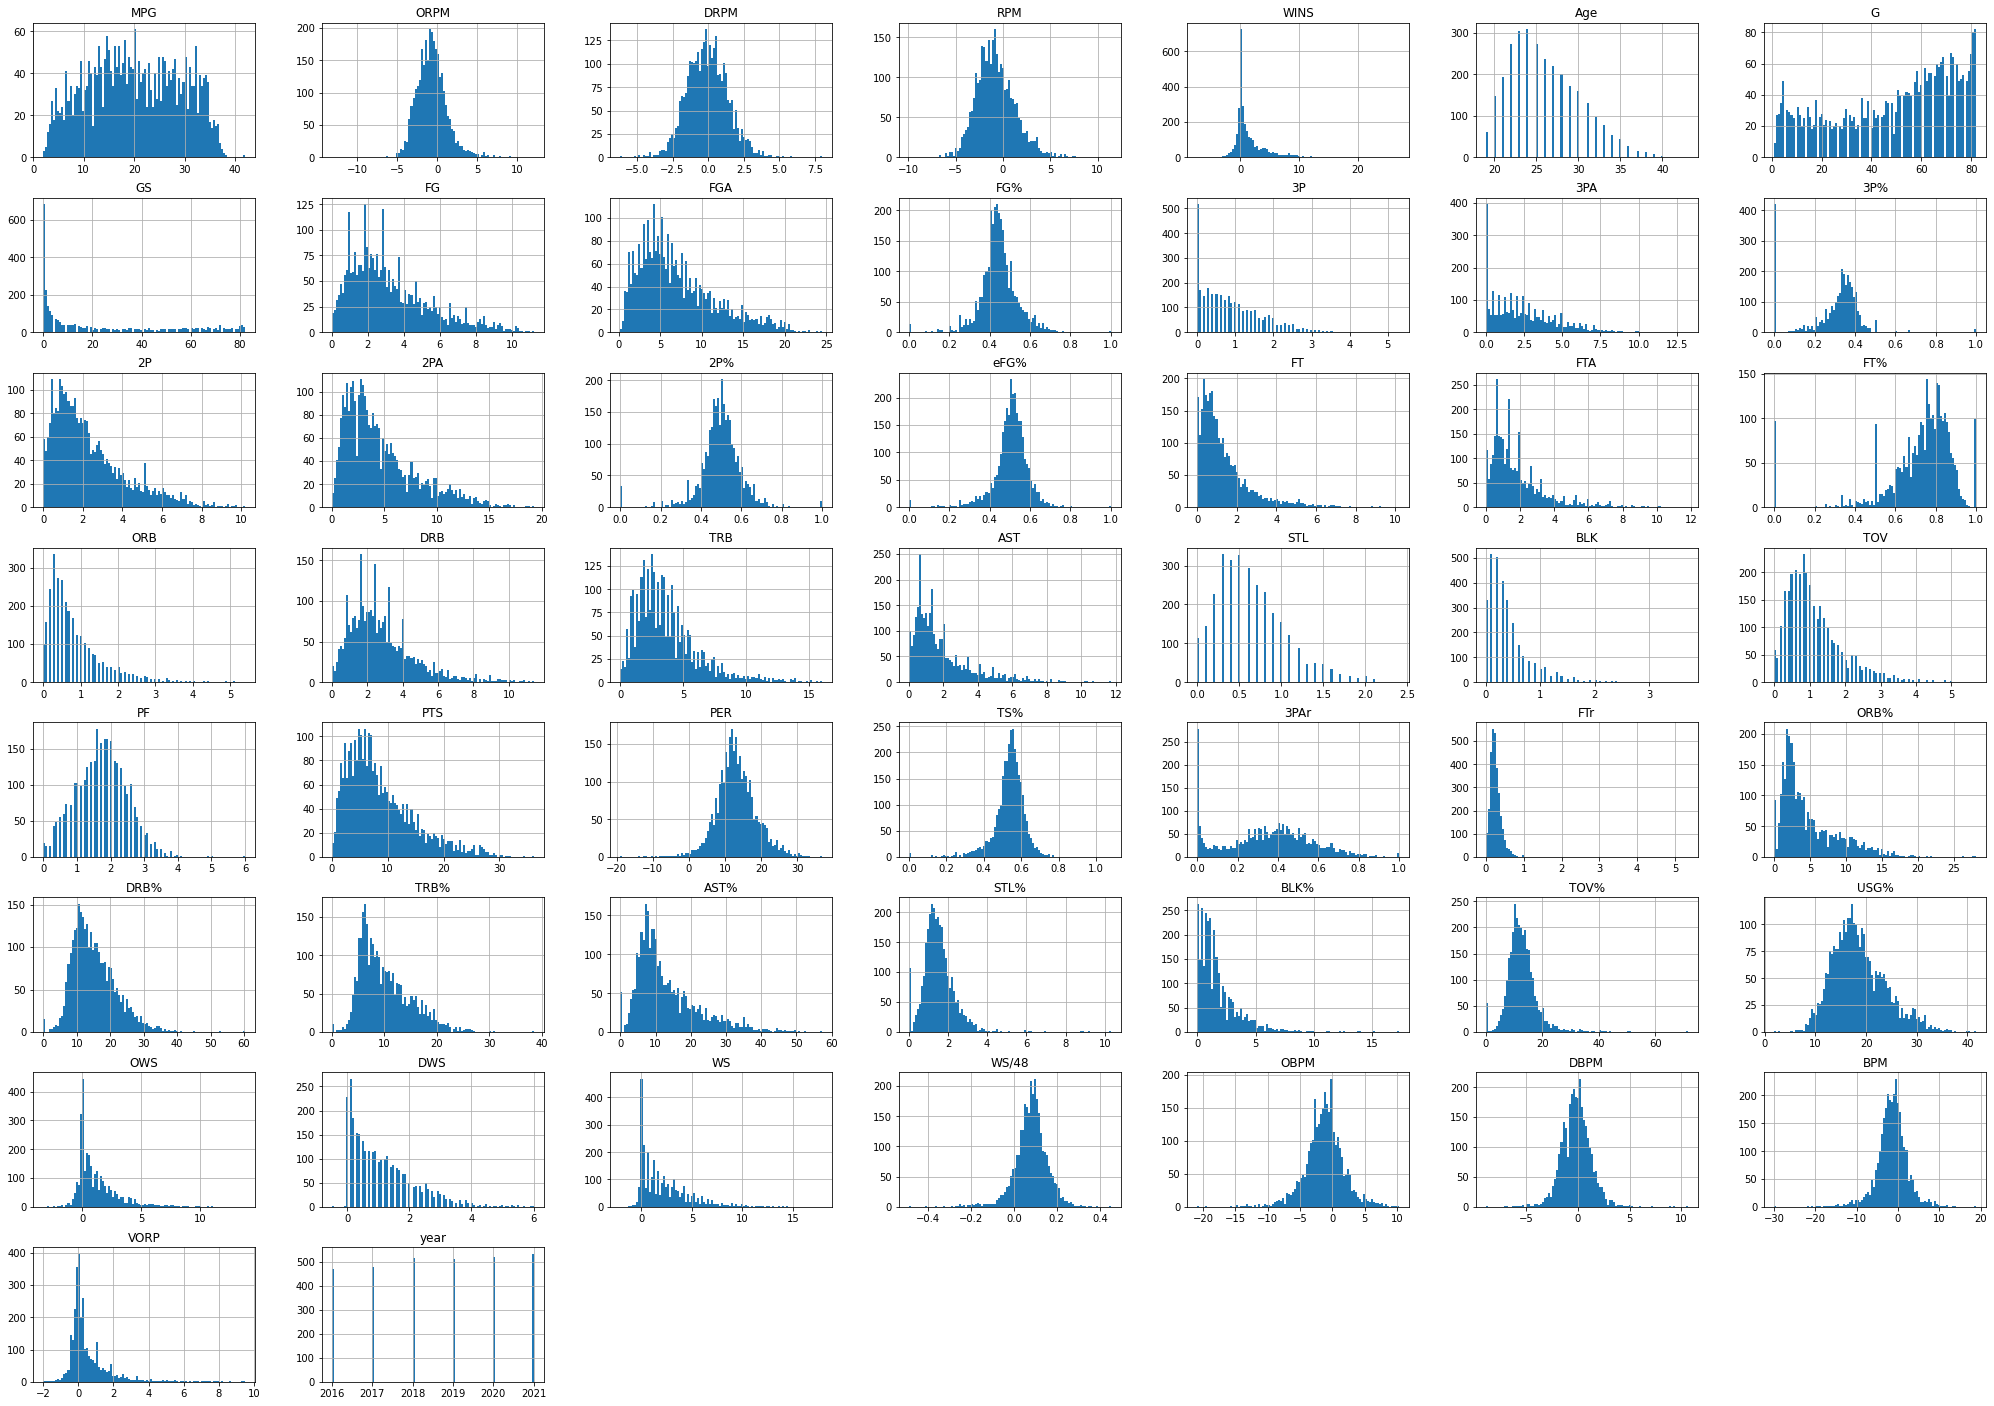

In [ ]:
df_tot.hist(figsize = (35,25), bins = 100);

Much of this data looks normally distributed which is interesting in that it helps to confirm the central limit theorem that when independent random variables are added, their properly normalized sum tends toward a normal distribution. Let's next look at an overall scatter matrix of the features within the dataset. 

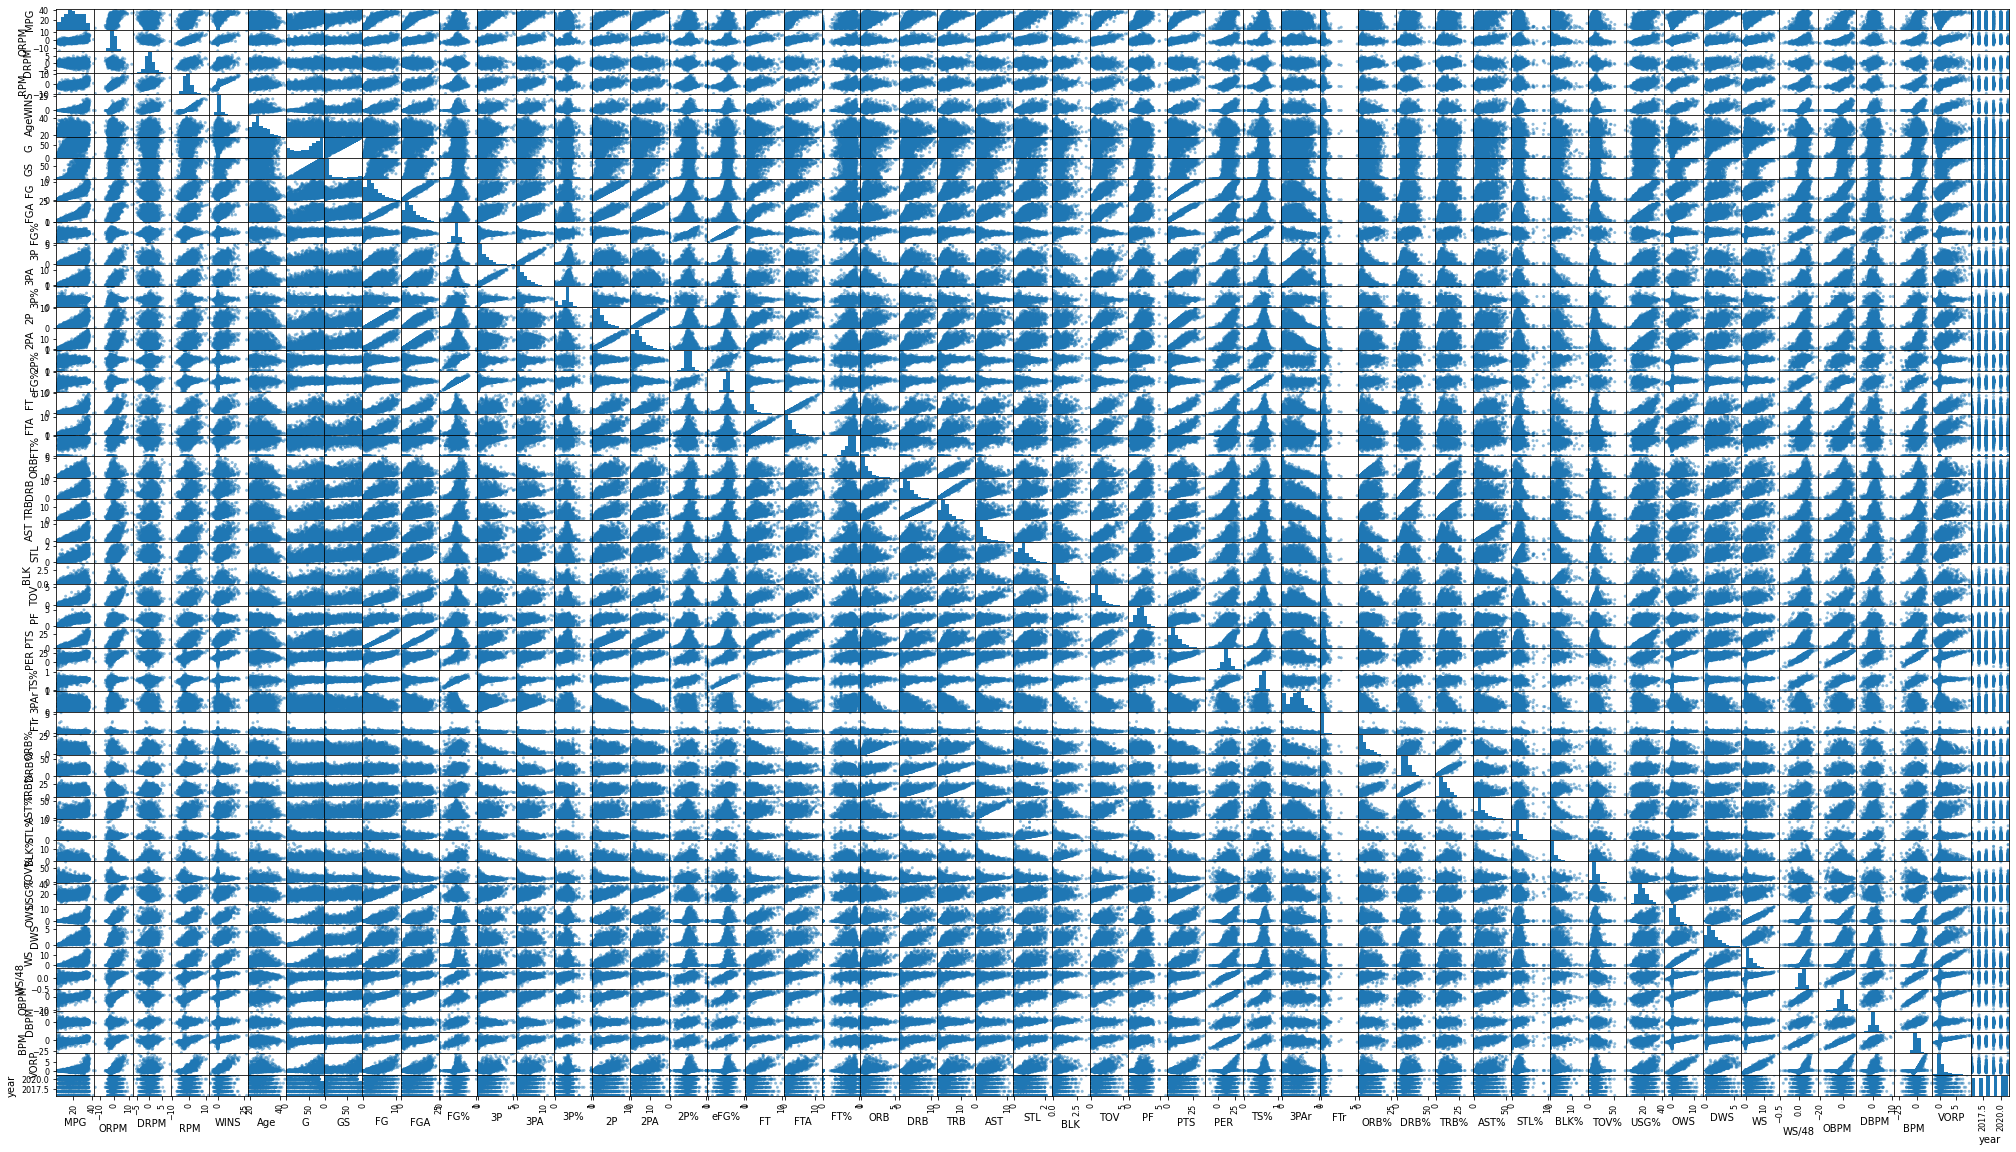

In [ ]:
pd.plotting.scatter_matrix(df_tot,figsize=(35,20))
plt.show()

As one can see, there's a lot going on here in terms of the interactions of various features. Some of these features are directly correlated to each other which lead to a one-to-one relationship. For example, ORPM is directly related to RPM as RPM is the sum of ORPM and DRPM. Thus the next point of focus is to answer specific questions about different features and their relationship to RPM. 

## Questions to answer: 
- How does points per game correlate with RPM?
- How does the number of 3 pointers made affect RPM?
- What effect do traditional-based advanced statistics have on RPM?

#### How does points correlate with RPM?

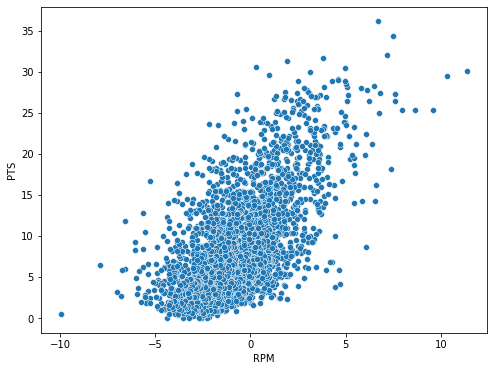

The correlation between Points and RPM is 0.627


In [77]:
plt.figure(figsize= (8,6))
matplotlib
sns.scatterplot(data = df_tot, x = 'RPM', y = 'PTS')
plt.show()
print(f'The correlation between Points and RPM is {round(df_tot.RPM.corr(df_tot.PTS),3)}')

It looks points and RPM are positively correlated. This is logical as points intuitively relates to offensive impact which in turn would affect RPM. Let's next look at how the number of 3-pointers made affect RPM as the 3 point shot has become highly valued over time.
#### How does 3 pointers made correlate with RPM?

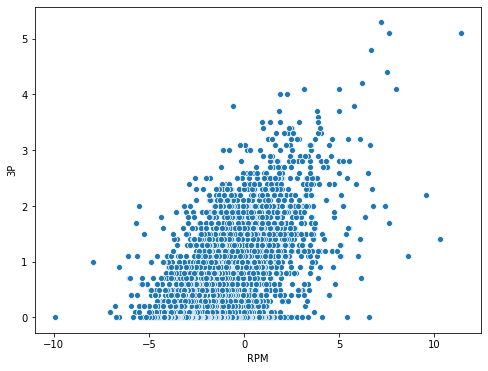

The correlation between 3-Pointers made and RPM is 0.538


In [12]:
plt.figure(figsize= (8,6))
sns.scatterplot(data = df_tot, x = 'RPM', y = '3P')
plt.show()
print(f'The correlation between 3-Pointers made and RPM is {round(df_tot.RPM.corr(df_tot["3P"]),3)}')

Surprisingly, the correlation between RPM and 3 pointers made is lower than expected. I say lower than expected as I thought the impact of the 3 point shot would be more than this correlation indicates. Let's next look at the advanced stats from basketball reference and analyze their correlation to RPM. 

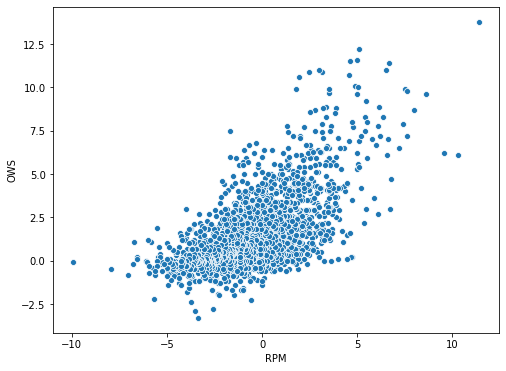

The correlation between OWS made and RPM is 0.643


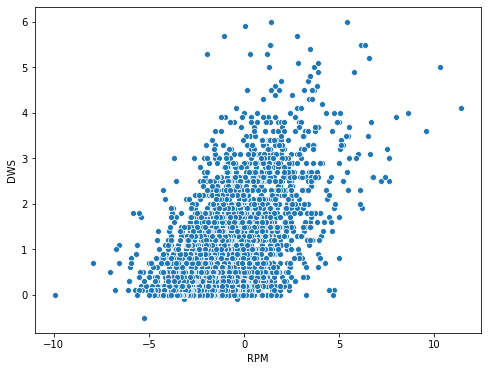

The correlation between DWS made and RPM is 0.541


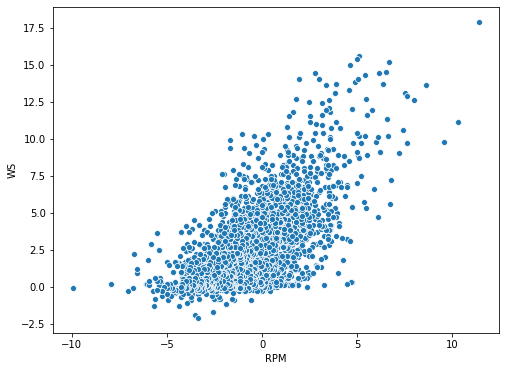

The correlation between WS made and RPM is 0.66


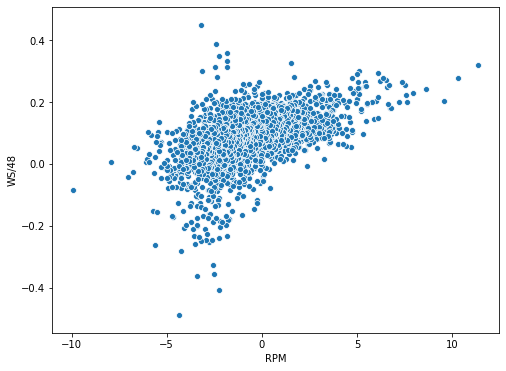

The correlation between WS/48 made and RPM is 0.518


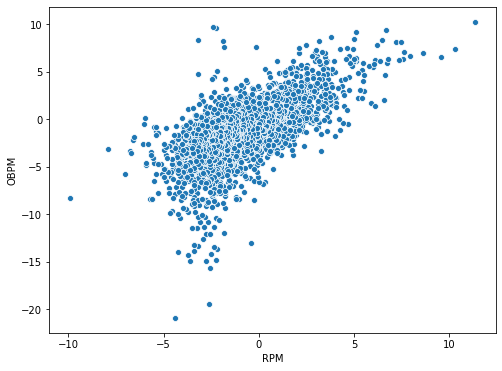

The correlation between OBPM made and RPM is 0.656


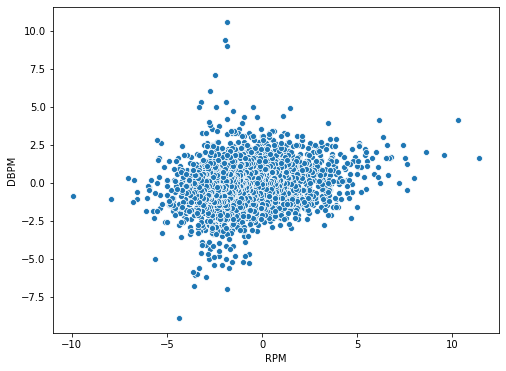

The correlation between DBPM made and RPM is 0.215


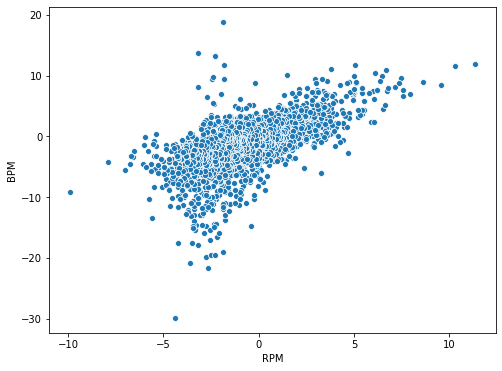

The correlation between BPM made and RPM is 0.626


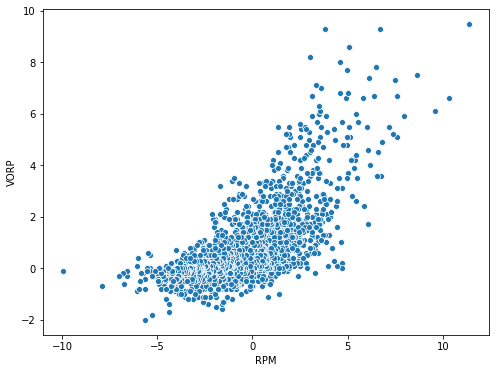

The correlation between VORP made and RPM is 0.695


In [ ]:
names = ['OWS', 'DWS', 'WS', 'WS/48',
       'OBPM', 'DBPM', 'BPM', 'VORP']
for name in names:
  plt.figure(figsize= (8,6))
  sns.scatterplot(data = df_tot, x = 'RPM', y = name)
  plt.show()
  print(f'The correlation between {name} made and RPM is {round(df_tot.RPM.corr(df_tot[name]),3)}')

It looks like OWS, WS, OBPM, BPM, and VORP are highly correlated with RPM. This analysis of basic and advanced statistics indicate that these features will have an impactful effect on the models that will be created. So let's find out if that is truly the case by beginning the modeling process!

# Model 

We'll first preparing the database for modeling by getting rid of columns that do not need to be included in the model. From there, we will prepare the training and testing sets for modeling.

In [13]:
# x = df_tot.drop(columns = ['NAME','TEAM','year','Pos','ORPM','DRPM','RPM','WINS','OWS', 'DWS',	'WS',	'WS/48',	'OBPM',	'DBPM',	'BPM'	,'VORP'])
x = df_tot.drop(columns = ['NAME','TEAM','year','Pos','ORPM','DRPM','RPM','WINS'])
# x = x.loc[(x.MPG > 10) & (x.G > 20)]
# x.drop(columns = ['G','GS','Age'], inplace = True)
x

MPG  Age   G  GS    FG   FGA    FG%   3P   3PA    3P%  ...  TOV%  USG%  \
0    34.2   32  63  63  10.4  21.7  0.482  5.3  12.7  0.421  ...  12.2  34.8   
1    33.4   36  45  45   9.4  18.3  0.513  2.3   6.3  0.365  ...  15.2  31.9   
2    30.8   28  71  71   5.5   8.2  0.675  0.0   0.1  0.000  ...  13.7  17.0   
3    33.7   30  54  54   8.2  17.6  0.467  3.2   7.7  0.411  ...  14.5  30.0   
4    33.0   26  61  61  10.3  18.0  0.569  1.1   3.6  0.303  ...  13.2  32.5   
..    ...  ...  ..  ..   ...   ...    ...  ...   ...    ...  ...   ...   ...   
463   7.6   25   8   0   1.0   3.1  0.320  0.1   1.0  0.125  ...  25.2  24.9   
464  18.0   22   8   3   2.8   8.1  0.338  0.4   2.1  0.176  ...  26.3  33.5   
465  19.9   23  66  52   2.2   6.2  0.355  1.1   3.7  0.290  ...   8.6  16.4   
466  10.7   20  63   9   1.4   3.3  0.427  0.4   1.3  0.316  ...  12.8  17.4   
467  23.2   29  81  81   2.2   5.1  0.443  0.0   0.0  0.000  ...  13.8  12.9   

     OWS  DWS    WS  WS/48  OBPM  DBPM   BPM  VORP  
0    6.5  2.5   9.0  0.201   8.1   0.0   8.1   5.5  
1    3.0  2.6   5.6  0.179   5.9   1.6   7.5   3.6  
2    6.1  5.2  11.3  0.248   2.0   2.5   4.5   3.6  
3    3.0  2.3   5.3  0.139   4.0  -0.4   3.7   2.6  
4    6.9  3.3  10.2  0.244   6.2   2.6   8.8   5.5  
..   ...  ...   ...    ...   ...   ...   ...   ...  
463 -0.3  0.1  -0.2 -0.157  -6.5  -1.9  -8.4  -0.1  
464 -0.8  0.0  -0.8 -0.263  -8.4  -5.0 -13.4  -0.4  
465 -0.6  1.1   0.6  0.021  -3.8  -0.7  -4.5  -0.8  
466 -0.3  0.7   0.4  0.031  -4.6  -0.5  -5.1  -0.5  
467  1.1  1.0   2.2  0.056  -3.5   0.2  -3.2  -0.6  

[3025 rows x 46 columns]

In [14]:
# y = df_tot.loc[(df_tot.MPG > 10) & (df_tot.G > 20)].RPM
y = df_tot.RPM

In [15]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = .25, random_state = 123)

Let's also scale the datasets in order to analyze the results of models that use scaled data to train. 

In [16]:
standard_scaler = StandardScaler()
X_train_scaled_standard = standard_scaler.fit_transform(X_train)
X_test_scaled_standard = standard_scaler.transform(X_test)

minmax_scaler = MinMaxScaler()
X_train_scaled_minmax = minmax_scaler.fit_transform(X_train)
X_test_scaled_minmax = minmax_scaler.transform(X_test)

maxabs_scaler = MaxAbsScaler()
X_train_scaled_maxabs = maxabs_scaler.fit_transform(X_train)
X_test_scaled_maxabs = maxabs_scaler.transform(X_test)


The next task we need is create a function that evaluates the results of the models we will run. The three points of evaluation for analyzing the results of the model are:
- Mean Squared Error: Represents the average of the squared difference between the original and predicted values in the data set. It measures the variance of the residuals. 
$$ MSE = \frac{1}{N}\sum_{i=1}^{N}(y_{true}-y_{pred})^2 $$
- Mean Absolute Error: Represents the average of the absolute difference between the actual and predicted values in the dataset. It measures the average of the residuals in the dataset.
$$ MAE = \frac{1}{N}\sum_{i=1}^{N}\lvert y_{true}-y_{pred} \rvert$$
- Coefficient of determination (R-squared): Represents the proportion of the variance in the dependent variable which is explained by a model
$$ R^2 = 1-\frac{\sum_{i=1}^{N}(y_{true}-y_{pred})^2}{\sum_{i=1}^{N}(y_{true}-y_{avg})^2}$$

These three metrics will be how we determine our models' performances. The function below prints these 3 metrics for both the training and testing set.

In [17]:
def evaluate_results(model,X_test = X_test,y_test = y_test, X_train = X_train, y_train = y_train):
  test_preds = model.predict(X_test)
  train_preds = model.predict(X_train)
  print('--------------------')
  print('Model Results:')
  print(f'Training MSE: {MSE(y_train,train_preds)}')
  print(f'Test MSE: {MSE(y_test,test_preds)}')
  print(f'Training MAE: {MAE(y_train,train_preds)}')
  print(f'Test MAE: {MAE(y_test,test_preds)}')
  print(f'Training R-Squared: {r2_score(y_train,train_preds)}')
  print(f'Test R-Squared: {r2_score(y_test,test_preds)}')
  print('--------------------')

The initial modeling process will consist of an analysis on what type of scaling will be used for each type of model we will implement. The types of scaling we will analyze is:
- No scaling
- Standard Scaling
- MinMax Scaling
- MaxAbs Scaling

The models we will initially implement are base models of the following: 
- XGBoost
- Decision Tree
- AdaBoost
- Gradient Boost
- Random Forest
- Bagging
- K-Nearest Neighbors

From here we will then performing GridSearch Cross-validation on each of the models using the dataset that performs the best for each respective model.

## Iteration #1: Base XGBoost Model


In [ ]:
xgb_base = xgb.XGBRegressor(random_state = 4)
xgb_base.fit(X_train,y_train)
evaluate_results(xgb_base)

/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:36:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--------------------
Model Results:
Training MSE: 1.1194876736975763
Test MSE: 1.7292923621035035
Training MAE: 0.8181826574235787
Test MAE: 1.0115626532839344
Training R-Squared: 0.752674221853965
Test R-Squared: 0.5759234669148728
--------------------


In [ ]:
xgb_base_standard = xgb.XGBRegressor(random_state = 4)
xgb_base_standard.fit(X_train_scaled_standard,y_train)
evaluate_results(xgb_base_standard, X_train = X_train_scaled_standard, X_test = X_test_scaled_standard)

[16:36:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


--------------------
Model Results:
Training MSE: 1.1194876736975763
Test MSE: 1.7283119972585046
Training MAE: 0.8181826574235787
Test MAE: 1.0111874743276417
Training R-Squared: 0.752674221853965
Test R-Squared: 0.5761638830143923
--------------------


In [ ]:
xgb_base_minmax = xgb.XGBRegressor(random_state = 4)
xgb_base_minmax.fit(X_train_scaled_minmax,y_train)
evaluate_results(xgb_base_minmax, X_train = X_train_scaled_minmax, X_test = X_test_scaled_minmax)

[16:36:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


--------------------
Model Results:
Training MSE: 1.1194876736975763
Test MSE: 1.7292923621035035
Training MAE: 0.8181826574235787
Test MAE: 1.0115626532839344
Training R-Squared: 0.752674221853965
Test R-Squared: 0.5759234669148728
--------------------


In [ ]:
xgb_base_maxabs = xgb.XGBRegressor(random_state = 4)
xgb_base_maxabs.fit(X_train_scaled_maxabs,y_train)
evaluate_results(xgb_base_maxabs, X_train = X_train_scaled_maxabs, X_test = X_test_scaled_maxabs)

[16:36:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


--------------------
Model Results:
Training MSE: 1.1194876736975763
Test MSE: 1.7292923621035035
Training MAE: 0.8181826574235787
Test MAE: 1.0115626532839344
Training R-Squared: 0.752674221853965
Test R-Squared: 0.5759234669148728
--------------------


### Discussion

It looks like the best performing model comes from when the data uses StandardScaler. Let's next transition to evaluating Decision tree models to see which type of scaled data performs best. 



## Iteration #2: Base Decision Tree Model

In [ ]:
dt_base = DecisionTreeRegressor(random_state= 4)
dt_base.fit(X_train,y_train)
evaluate_results(dt_base)

--------------------
Model Results:
Training MSE: 0.0
Test MSE: 3.4717064729194185
Training MAE: 0.0
Test MAE: 1.4018758256274768
Training R-Squared: 1.0
Test R-Squared: 0.1486290709489977
--------------------


In [ ]:
dt_base_standard = DecisionTreeRegressor(random_state= 4)
dt_base_standard.fit(X_train_scaled_standard,y_train)
evaluate_results(dt_base_standard, X_train = X_train_scaled_standard, X_test = X_test_scaled_standard)

--------------------
Model Results:
Training MSE: 0.0
Test MSE: 3.473324042272127
Training MAE: 0.0
Test MAE: 1.4045310435931309
Training R-Squared: 1.0
Test R-Squared: 0.14823239238951635
--------------------


In [ ]:
dt_base_minmax = DecisionTreeRegressor(random_state= 4)
dt_base_minmax.fit(X_train_scaled_minmax,y_train)
evaluate_results(dt_base_minmax, X_train = X_train_scaled_minmax, X_test = X_test_scaled_minmax)

--------------------
Model Results:
Training MSE: 0.0
Test MSE: 3.4957857331571995
Training MAE: 0.0
Test MAE: 1.408639365918098
Training R-Squared: 1.0
Test R-Squared: 0.14272408378507395
--------------------


In [ ]:
dt_base_maxabs = DecisionTreeRegressor(random_state= 4)
dt_base_maxabs.fit(X_train_scaled_maxabs,y_train)
evaluate_results(dt_base_maxabs, X_train = X_train_scaled_maxabs, X_test = X_test_scaled_maxabs)

--------------------
Model Results:
Training MSE: 0.0
Test MSE: 3.515859180977543
Training MAE: 0.0
Test MAE: 1.4116776750330253
Training R-Squared: 1.0
Test R-Squared: 0.13780144702030983
--------------------


### Discussion

It looks like the best performing model comes from when the data uses StandardScaler. Let's next transition to evaluating Adaboost models to see which type of scaled data performs best. 

## Iteration #3: Base AdaBoost Model



In [ ]:
adb_reg = AdaBoostRegressor(random_state = 4)
adb_reg.fit(X_train,y_train)
evaluate_results(adb_reg)

--------------------
Model Results:
Training MSE: 1.6761107289314063
Test MSE: 2.0269510833809137
Training MAE: 1.0348404427671962
Test MAE: 1.1028497893633753
Training R-Squared: 0.6297007997214759
Test R-Squared: 0.5029282456740118
--------------------


In [ ]:
adb_reg_standard = AdaBoostRegressor(random_state = 4)
adb_reg_standard.fit(X_train_scaled_standard,y_train)
evaluate_results(adb_reg_standard, X_train = X_train_scaled_standard, X_test = X_test_scaled_standard)

--------------------
Model Results:
Training MSE: 1.6637010024279566
Test MSE: 2.0752147618412136
Training MAE: 1.0309785047033435
Test MAE: 1.1160140320181178
Training R-Squared: 0.6324424514038991
Test R-Squared: 0.49109248332178435
--------------------


In [ ]:
adb_reg_minmax = AdaBoostRegressor(random_state = 4)
adb_reg_minmax.fit(X_train_scaled_minmax,y_train)
evaluate_results(adb_reg_minmax, X_train = X_train_scaled_minmax, X_test = X_test_scaled_minmax)

--------------------
Model Results:
Training MSE: 1.643963204775453
Test MSE: 2.0098460423458064
Training MAE: 1.0270045741928304
Test MAE: 1.1007495961171208
Training R-Squared: 0.6368030766059353
Test R-Squared: 0.507122936322864
--------------------


In [ ]:
adb_reg_maxabs = AdaBoostRegressor(random_state = 4)
adb_reg_maxabs.fit(X_train_scaled_maxabs,y_train)
evaluate_results(adb_reg_maxabs, X_train = X_train_scaled_maxabs, X_test = X_test_scaled_maxabs)

--------------------
Model Results:
Training MSE: 1.6704523776619367
Test MSE: 2.0465806033460225
Training MAE: 1.0338716823209029
Test MAE: 1.1075436947528776
Training R-Squared: 0.6309508859561217
Test R-Squared: 0.4981144738935115
--------------------


### Discussion

It looks like the best performing model comes from when the data uses 
MinMaxScaler. Let's next transition to evaluating Gradient Boost 
models to see which type of scaled data performs best. 

## Iteration #4: Base Gradient Boost Model




In [ ]:
gb_base = GradientBoostingRegressor(random_state = 4)
gb_base.fit(X_train,y_train)
evaluate_results(gb_base)

--------------------
Model Results:
Training MSE: 1.0914717747088136
Test MSE: 1.7104438790480856
Training MAE: 0.8108329645846799
Test MAE: 1.0075764156245373
Training R-Squared: 0.7588637085099192
Test R-Squared: 0.5805457040352244
--------------------


In [ ]:
gb_base_standard = GradientBoostingRegressor(random_state = 4)
gb_base_standard.fit(X_train_scaled_standard,y_train)
evaluate_results(gb_base_standard, X_train = X_train_scaled_standard, X_test = X_test_scaled_standard)

--------------------
Model Results:
Training MSE: 1.0914717747088136
Test MSE: 1.7104713357579195
Training MAE: 0.8108329645846799
Test MAE: 1.007635143326866
Training R-Squared: 0.7588637085099192
Test R-Squared: 0.5805389707918636
--------------------


In [ ]:
gb_base_minmax = GradientBoostingRegressor(random_state = 123)
gb_base_minmax.fit(X_train_scaled_minmax,y_train)
evaluate_results(gb_base_minmax, X_train = X_train_scaled_minmax, X_test = X_test_scaled_minmax)

--------------------
Model Results:
Training MSE: 1.0914717747088136
Test MSE: 1.7087370935749595
Training MAE: 0.8108329645846799
Test MAE: 1.006831769121271
Training R-Squared: 0.7588637085099192
Test R-Squared: 0.5809642611757204
--------------------


In [ ]:
gb_base_maxabs = GradientBoostingRegressor(random_state = 123)
gb_base_maxabs.fit(X_train_scaled_maxabs,y_train)
evaluate_results(gb_base_maxabs, X_train = X_train_scaled_maxabs, X_test = X_test_scaled_maxabs)

--------------------
Model Results:
Training MSE: 1.0914717747088136
Test MSE: 1.70925225130876
Training MAE: 0.8108329645846799
Test MAE: 1.0070329053384421
Training R-Squared: 0.7588637085099192
Test R-Squared: 0.5808379283990716
--------------------


### Discussion

It looks like the best performing model comes from when the data uses MinMaxScaler. Let's next transition to evaluating Random Forest models to see which type of scaled data performs best.



## Iteration #5: Base Random Forest Model





In [ ]:
rf_base = RandomForestRegressor(random_state = 123)
rf_base.fit(X_train,y_train)
evaluate_results(rf_base)

--------------------
Model Results:
Training MSE: 0.23420374413139333
Test MSE: 1.7435684105812417
Training MAE: 0.3714276455026455
Test MAE: 1.022512681638045
Training R-Squared: 0.9482579177752879
Test R-Squared: 0.5724225336561206
--------------------


In [ ]:
rf_base_standard = RandomForestRegressor(random_state = 123)
rf_base_standard.fit(X_train_scaled_standard,y_train)
evaluate_results(rf_base_standard, X_train = X_train_scaled_standard, X_test = X_test_scaled_standard)

--------------------
Model Results:
Training MSE: 0.23432751393738982
Test MSE: 1.7470187963276094
Training MAE: 0.37130013227513226
Test MAE: 1.0236470277410832
Training R-Squared: 0.9482305736032185
Test R-Squared: 0.5715763912355607
--------------------


In [ ]:
rf_base_minmax = RandomForestRegressor(random_state = 123)
rf_base_minmax.fit(X_train_scaled_minmax,y_train)
evaluate_results(rf_base_minmax, X_train = X_train_scaled_minmax, X_test = X_test_scaled_minmax)

--------------------
Model Results:
Training MSE: 0.23389118897707234
Test MSE: 1.7439682277542934
Training MAE: 0.37094012345679017
Test MAE: 1.023096036988111
Training R-Squared: 0.9483269698502435
Test R-Squared: 0.5723244859897274
--------------------


In [ ]:
rf_base_maxabs = RandomForestRegressor(random_state = 123)
rf_base_maxabs.fit(X_train_scaled_maxabs,y_train)
evaluate_results(rf_base_maxabs, X_train = X_train_scaled_maxabs, X_test = X_test_scaled_maxabs)

--------------------
Model Results:
Training MSE: 0.23356490359788365
Test MSE: 1.748192384280053
Training MAE: 0.3706285714285715
Test MAE: 1.0244998678996036
Training R-Squared: 0.9483990553114785
Test R-Squared: 0.5712885907912579
--------------------


### Discussion

It looks like the best performing model comes from when the data uses no scaler. Let's next transition to evaluating Bagging models to see which type of scaled data performs best. 


## Iteration #6: Base Bagging Model


In [ ]:
bag_base = BaggingRegressor(random_state = 123)
bag_base.fit(X_train,y_train)
evaluate_results(bag_base)

--------------------
Model Results:
Training MSE: 0.3349007248677249
Test MSE: 1.8961225125495376
Training MAE: 0.4203659611992946
Test MAE: 1.0663619550858654
Training R-Squared: 0.9260111707116865
Test R-Squared: 0.5350115000516376
--------------------


In [ ]:
bag_base_standard = BaggingRegressor(random_state = 123)
bag_base_standard.fit(X_train_scaled_standard,y_train)
evaluate_results(bag_base_standard, X_train = X_train_scaled_standard, X_test = X_test_scaled_standard)

--------------------
Model Results:
Training MSE: 0.3350306119929453
Test MSE: 1.9065739431968294
Training MAE: 0.4208518518518518
Test MAE: 1.0698295904887714
Training R-Squared: 0.925982475054672
Test R-Squared: 0.5324484826164065
--------------------


In [ ]:
bag_base_minmax = BaggingRegressor(random_state = 123)
bag_base_minmax.fit(X_train_scaled_minmax,y_train)
evaluate_results(bag_base_minmax, X_train = X_train_scaled_minmax, X_test = X_test_scaled_minmax)

--------------------
Model Results:
Training MSE: 0.3348856322751323
Test MSE: 1.904227321003963
Training MAE: 0.4208871252204586
Test MAE: 1.0682192866578601
Training R-Squared: 0.9260145050826625
Test R-Squared: 0.5330239477175194
--------------------


In [ ]:
bag_base_maxabs = BaggingRegressor(random_state = 123)
bag_base_maxabs.fit(X_train_scaled_maxabs,y_train)
evaluate_results(bag_base_maxabs, X_train = X_train_scaled_maxabs, X_test = X_test_scaled_maxabs)

--------------------
Model Results:
Training MSE: 0.3346808492063492
Test MSE: 1.8935763593130779
Training MAE: 0.42049735449735454
Test MAE: 1.0660607661822985
Training R-Squared: 0.9260597473242949
Test R-Squared: 0.5356358964006204
--------------------


### Discussion

It looks like the best performing model comes from when the data uses MaxAbsScaler. Let's next transition to evaluating KNN models to see which type of scaled data performs best.

## Iteration #7: Base KNN Model


In [ ]:
knn_base = KNeighborsRegressor()
knn_base.fit(X_train,y_train)
evaluate_results(knn_base)

--------------------
Model Results:
Training MSE: 1.6087281216931217
Test MSE: 2.3405032602377807
Training MAE: 0.9797680776014109
Test MAE: 1.1911862615587847
Training R-Squared: 0.6445874806204916
Test R-Squared: 0.4260354524039308
--------------------


In [ ]:
knn_base_standard = KNeighborsRegressor()
knn_base_standard.fit(X_train_scaled_standard,y_train)
evaluate_results(knn_base_standard, X_train = X_train_scaled_standard, X_test = X_test_scaled_standard)

--------------------
Model Results:
Training MSE: 1.288511377425044
Test MSE: 1.951278885072655
Training MAE: 0.8844559082892416
Test MAE: 1.0817516512549539
Training R-Squared: 0.7153322126191104
Test R-Squared: 0.5214854336965515
--------------------


In [ ]:
knn_base_minmax = KNeighborsRegressor()
knn_base_minmax.fit(X_train_scaled_minmax,y_train)
evaluate_results(knn_base_minmax, X_train = X_train_scaled_minmax, X_test = X_test_scaled_minmax)

--------------------
Model Results:
Training MSE: 1.34216417989418
Test MSE: 2.0119729405548217
Training MAE: 0.9004232804232803
Test MAE: 1.1052708058124174
Training R-Squared: 0.7034788251882638
Test R-Squared: 0.5066013544096664
--------------------


In [ ]:
knn_base_maxabs = KNeighborsRegressor()
knn_base_maxabs.fit(X_train_scaled_maxabs,y_train)
evaluate_results(knn_base_maxabs, X_train = X_train_scaled_maxabs, X_test = X_test_scaled_maxabs)

--------------------
Model Results:
Training MSE: 1.3090622310405646
Test MSE: 1.997341854689564
Training MAE: 0.8849003527336861
Test MAE: 1.0998467635402907
Training R-Squared: 0.7107919608758857
Test R-Squared: 0.5101893539318882
--------------------


### Discussion

It looks like the best performing model comes from when the data uses StandardScaler. 

Let's now transition to implementing GridSearch Cross-Validation on each of the models previously outlined. The models will be trained on the two types of data they performed best on:
- XGBoost: 
  - StandardScaler
  - Original Data
- Decision Tree:
  - MaxAbsScaler
  - Original Data
- Gradient Boosting: 
  - All 4 types of data will be used as the results are close enough that it warrants extensive searching
- Adaboost: 
  - MinMaxScaler
  - Original Data
- Random Forest:
  - MinMaxScaler
  - Original Data
- Bagging: 
  - MaxAbsScaler
  - Original Data
- KNN:
  - Gridsearch will not be used as KNN only has one key hyperparameter (n_neighbors)
  - Instead we will implement our own function to find the best n_neighbor parameter on the following types of data:
      - StandardScaler
      - MaxAbsScaler


## Iteration #8 Implementing GridSearchCV on a XGBoost model





In [ ]:
xgb_gs = xgb.XGBRegressor(random_state = 123,objective ='reg:squarederror')

xgb_grid = {
            'learning_rate': [0.01, 0.1, 0.001], 
            'gamma': [ 0.01, 0.1], 
            'max_depth':  [2, 4, 5, 7], 
            'min_child_weight': [0.1, 1, 5, 10], 
            'subsample': [0.5, 0.7, 0.9], 
            'n_estimators': [40,60,100, 120]}
xgb_gridsearch = GridSearchCV(estimator=xgb_gs, 
                              param_grid=xgb_grid, 
                              cv = 5, 
                              return_train_score=True,n_jobs = -1)

xgb_gridsearch.fit(X_train, y_train)

print('Best Parameters for Our XGBoost Model:')
xgb_gridsearch.best_params_



/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Best Parameters for Our XGBoost Model:


{'gamma': 0.01,
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 10,
 'n_estimators': 100,
 'subsample': 0.5}

In [ ]:
evaluate_results(xgb_gridsearch)

--------------------
Model Results:
Training MSE: 0.8673880202878274
Test MSE: 1.7396751685132565
Training MAE: 0.7169288775960814
Test MAE: 1.0199477825249834
Training R-Squared: 0.8083700052152704
Test R-Squared: 0.5733772782874125
--------------------


In [ ]:
xgb_gs_standard = xgb.XGBRegressor(random_state = 123,objective ='reg:squarederror')

xgb_gridsearch_standard = GridSearchCV(estimator=xgb_gs_standard, 
                              param_grid=xgb_grid, 
                              cv = 5, 
                              return_train_score=True,n_jobs = -1)

xgb_gridsearch_standard.fit(X_train_scaled_standard, y_train)

print('Best Parameters for Our XGBoost Model:')
xgb_gridsearch_standard.best_params_



/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Best Parameters for Our XGBoost Model:


{'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 100,
 'subsample': 0.9}

In [ ]:
evaluate_results(xgb_gridsearch_standard, X_test = X_test_scaled_standard, X_train = X_train_scaled_standard, y_train = y_train, y_test = y_test)

--------------------
Model Results:
Training MSE: 0.7907298330667935
Test MSE: 1.69555124769545
Training MAE: 0.6790806592225608
Test MAE: 1.0036859286792055
Training R-Squared: 0.8253059181789967
Test R-Squared: 0.5841978426850813
--------------------


### Discussion: 

These are our best results so far and more specifically the XGBoost model that is trained on standardized data is the best in terms of the 3 factors we have been looking at. Let's next see if using GridSearch on a Decision Tree model can obtain better results.

## Iteration #9 Implementing GridSearchCV on a Decision Tree model


In [ ]:
dt = DecisionTreeRegressor(random_state=123, criterion = 'mae')

dt_grid = {
            'min_samples_split': [2,6,8,10], 
            'min_samples_leaf': [ 0.2, 0.4,1], 
            'max_depth': [3, 5, 7, 9], 
            'max_features': [10, 20, 30,35, X_train.shape[1]]}
dt_gridsearch_standard = GridSearchCV(estimator=dt, 
                              param_grid=dt_grid, 
                              cv = 5, 
                              return_train_score=True, n_jobs = -1
                             )

dt_gridsearch_standard.fit(X_train_scaled_standard, y_train)

print('Best Parameters for Our Decision Tree Model:')
dt_gridsearch_standard.best_params_

Best Parameters for Our Decision Tree Model:


{'max_depth': 5,
 'max_features': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 8}

In [ ]:
evaluate_results(dt_gridsearch_standard, X_test = X_test_scaled_standard, X_train = X_train_scaled_standard)

--------------------
Model Results:
Training MSE: 1.6645033068783068
Test MSE: 2.2083721928665785
Training MAE: 0.9714462081128749
Test MAE: 1.1550726552179655
Training R-Squared: 0.6322652001691111
Test R-Squared: 0.4584381196402897
--------------------


In [ ]:
dt = DecisionTreeRegressor(random_state=123, criterion = 'mae')

dt_gridsearch = GridSearchCV(estimator=dt, 
                              param_grid=dt_grid, 
                              cv=5, 
                              return_train_score=True, n_jobs = -1
                             )

dt_gridsearch.fit(X_train, y_train)

print('Best Parameters for Our Decision Tree Model:')
dt_gridsearch.best_params_

Best Parameters for Our Decision Tree Model:


{'max_depth': 5,
 'max_features': 46,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [ ]:
evaluate_results(dt_gridsearch)

--------------------
Model Results:
Training MSE: 1.6281981922398587
Test MSE: 2.107964101717305
Training MAE: 0.9625617283950616
Test MAE: 1.1115389696169087
Training R-Squared: 0.6402860037381023
Test R-Squared: 0.4830613216629276
--------------------


### Discussion: 

These results are relatively poor but the Gridsearch implementation did improve the results from the base model. Let's next transition to using Gridsearch on an Adaboost model.

## Iteration #10 Implementing GridSearchCV on an Adaboost model


In [ ]:
adb_reg = AdaBoostRegressor(random_state = 123)

adb_grid = {
            'learning_rate': [0.01, 0.1, 0.001], 
            'n_estimators': [30, 50, 70, 100, 120, 140], 
            'loss': ['linear', 'square', 'exponential']}

adb_gridsearch = GridSearchCV(estimator=adb_reg, 
                              param_grid=adb_grid, 
                              cv= 5 , 
                              return_train_score=True,n_jobs = -1
                             )

adb_gridsearch.fit(X_train, y_train)
print('Best Parameters for Our AdaBoost Model:')
adb_gridsearch.best_params_


Best Parameters for Our AdaBoost Model:


{'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 120}

In [ ]:
evaluate_results(adb_gridsearch)

--------------------
Model Results:
Training MSE: 1.6609397253798377
Test MSE: 1.9357265338054201
Training MAE: 1.0133632557882242
Test MAE: 1.0813978613948525
Training R-Squared: 0.6330524938462131
Test R-Squared: 0.5252993562878181
--------------------


In [ ]:
adb_reg = AdaBoostRegressor(random_state = 123)

adb_gridsearch_minmax = GridSearchCV(estimator=adb_reg, 
                              param_grid=adb_grid, 
                              cv= 5 , 
                              return_train_score=True,n_jobs = -1
                             )

adb_gridsearch_minmax.fit(X_train_scaled_minmax, y_train)
print('Best Parameters for Our AdaBoost Model:')
adb_gridsearch_minmax.best_params_


Best Parameters for Our AdaBoost Model:


{'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 140}

In [ ]:
evaluate_results(adb_gridsearch_minmax, X_test = X_test_scaled_minmax, X_train = X_train_scaled_minmax)

--------------------
Model Results:
Training MSE: 1.6618624900924936
Test MSE: 1.9383356793019748
Training MAE: 1.0154383758420524
Test MAE: 1.0816015437495121
Training R-Squared: 0.6328486296090576
Test R-Squared: 0.524659512267951
--------------------


### Discussion: 

While these results are better than a tuned Decision Tree model, they are not better than XGBoost and thus we can now focus on implementing Gridsearch on the next model type which is Gradient Boosting. 

## Iteration #11 Implementing GridSearchCV on a Gradient Boosting model


In [ ]:
gb_reg = GradientBoostingRegressor(random_state = 123)

gb_grid = {
            'learning_rate': [0.01, 0.1, 0.001], 
            'n_estimators': [80,100,120, 140 ,170, 200 ], 
            'loss': ['ls', 'lad', 'huber', 'quantile'],
            'subsample': [0.5, 0.7, 0.9, 1]}

gb_gridsearch = GridSearchCV(estimator=gb_reg, 
                              param_grid=gb_grid, 
                              cv= 5 , 
                              return_train_score=True, n_jobs = -1
                             )

gb_gridsearch.fit(X_train, y_train)
print('Best Parameters for Our Gradient Boosting Model:')
gb_gridsearch.best_params_

Best Parameters for Our Gradient Boosting Model:


{'learning_rate': 0.1, 'loss': 'ls', 'n_estimators': 100, 'subsample': 0.7}

In [ ]:
evaluate_results(gb_gridsearch)

--------------------
Model Results:
Training MSE: 1.0853142162685023
Test MSE: 1.7085222551808668
Training MAE: 0.81387093605151
Test MAE: 1.0111642103640177
Training R-Squared: 0.7602240834104304
Test R-Squared: 0.5810169462643364
--------------------


In [ ]:
gb_reg = GradientBoostingRegressor(random_state = 123)

gb_gridsearch_minmax = GridSearchCV(estimator=gb_reg, 
                              param_grid=gb_grid, 
                              cv= 5 , 
                              return_train_score=True, n_jobs = -1
                             )

gb_gridsearch_minmax.fit(X_train_scaled_minmax, y_train)
print('Best Parameters for Our Gradient Boosting Model:')
gb_gridsearch_minmax.best_params_

Best Parameters for Our Gradient Boosting Model:


{'learning_rate': 0.1, 'loss': 'huber', 'n_estimators': 170, 'subsample': 0.9}

In [ ]:
evaluate_results(gb_gridsearch_minmax, X_test_scaled_minmax, X_train = X_train_scaled_minmax)

--------------------
Model Results:
Training MSE: 0.9227836987206676
Test MSE: 1.7615902787959425
Training MAE: 0.7194063640162109
Test MAE: 1.015546163477295
Training R-Squared: 0.7961315682978927
Test R-Squared: 0.5680030083290608
--------------------


In [ ]:
gb_reg = GradientBoostingRegressor(random_state = 123)

gb_gridsearch_maxabs = GridSearchCV(estimator=gb_reg, 
                              param_grid=gb_grid, 
                              cv= 5 , 
                              return_train_score=True, n_jobs = -1
                             )

gb_gridsearch_maxabs.fit(X_train_scaled_maxabs, y_train)
print('Best Parameters for Our Gradient Boosting Model:')
gb_gridsearch_maxabs.best_params_

Best Parameters for Our Gradient Boosting Model:


{'learning_rate': 0.1, 'loss': 'huber', 'n_estimators': 170, 'subsample': 0.9}

In [ ]:
evaluate_results(gb_gridsearch_maxabs, X_train = X_train_scaled_maxabs, X_test = X_test_scaled_maxabs)

--------------------
Model Results:
Training MSE: 0.92271174402189
Test MSE: 1.7631334915002157
Training MAE: 0.7193698473927408
Test MAE: 1.015950564049644
Training R-Squared: 0.7961474650802195
Test R-Squared: 0.567624564343658
--------------------


In [ ]:
gb_reg = GradientBoostingRegressor(random_state = 123)

gb_gridsearch_standard = GridSearchCV(estimator=gb_reg, 
                              param_grid=gb_grid, 
                              cv= 5 , 
                              return_train_score=True, n_jobs = -1
                             )

gb_gridsearch_standard.fit(X_train_scaled_standard, y_train)
print('Best Parameters for Our Gradient Boosting Model:')
gb_gridsearch_standard.best_params_

Best Parameters for Our Gradient Boosting Model:


{'learning_rate': 0.1, 'loss': 'ls', 'n_estimators': 120, 'subsample': 0.7}

In [ ]:
evaluate_results(gb_gridsearch_standard, X_train = X_train_scaled_standard, X_test = X_test_scaled_standard)

--------------------
Model Results:
Training MSE: 1.019046870482636
Test MSE: 1.7008709772568527
Training MAE: 0.7893187033908043
Test MAE: 1.0126164277471381
Training R-Squared: 0.7748643722204251
Test R-Squared: 0.5828932787381234
--------------------


### Discussion: 

These results are very comparable to the tuned and standard scaled Adaboost model. More specifically the Gradient Boosting models that are trained on non-scaled and standard data are the two best performing models. Let's next see if we can get comparable or better results by tuning a Random Forest model. 

## Iteration #12 Implementing GridSearchCV on a Random Forest model

In [ ]:
rf_reg = RandomForestRegressor(criterion = 'mae', random_state = 123)
rf_param_grid = {
    'max_features': [10, 20, 30, X_train.shape[1]],
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

rf_gridsearch = GridSearchCV(estimator=rf_reg, 
                              param_grid=rf_param_grid, 
                              cv=5, 
                              return_train_score=True, #n_jobs = -1
                             )
rf_gridsearch.fit(X_train, y_train)
print('Best Parameters for Our Random Forest Model:')
rf_gridsearch.best_params_

Best Parameters for Our Random Forest Model:


{'max_depth': 10,
 'max_features': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 10}

In [ ]:
evaluate_results(rf_gridsearch)

--------------------
Model Results:
Training MSE: 0.9911086859501763
Test MSE: 1.7337520727840157
Training MAE: 0.7363788359788359
Test MAE: 1.0210861955085864
Training R-Squared: 0.7810366896043723
Test R-Squared: 0.5748298064758399
--------------------


In [ ]:
rf_reg = RandomForestRegressor(criterion = 'mae', random_state = 123)

rf_gridsearch_minmax = GridSearchCV(estimator=rf_reg, 
                              param_grid=rf_param_grid, 
                              cv=5, 
                              return_train_score=True, #n_jobs = -1
                             )
rf_gridsearch_minmax.fit(X_train_scaled_minmax, y_train)
print('Best Parameters for Our Random Forest Model:')
rf_gridsearch_minmax.best_params_

Best Parameters for Our Random Forest Model:


{'max_depth': 10,
 'max_features': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 10}

In [ ]:
evaluate_results(rf_gridsearch_minmax, X_train = X_train_scaled_minmax, X_test = X_test_scaled_minmax)

--------------------
Model Results:
Training MSE: 0.99113118277888
Test MSE: 1.7334348611459707
Training MAE: 0.7364138668430336
Test MAE: 1.0203576618229855
Training R-Squared: 0.7810317194329308
Test R-Squared: 0.5749075966833632
--------------------


### Discussion: 

These results are good but they are not better than the tuned XGBoost and Gradient Boosting models. Let's see how a tuned bagging model will perform. 

## Iteration #13 Implementing GridSearchCV on a Bagging Model

In [ ]:
bag_reg = BaggingRegressor(random_state = 123)

bag_grid = {'n_estimators': [10, 30, 50, 70 ],
            'max_samples': [0.05, 0.1, 0.2, 0.5],
            'max_features': [.5, 1, 3, 5]}

bag_gridsearch_maxabs = GridSearchCV(estimator=bag_reg, 
                              param_grid=bag_grid, 
                              cv=10, 
                              return_train_score=True) #n_jobs = -1

bag_gridsearch_maxabs.fit(X_train_scaled_maxabs, y_train)
                                     
print('Best Parameters for Our Bagging Model:')
bag_gridsearch_maxabs.best_params_


Best Parameters for Our Bagging Model:


{'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 70}

In [ ]:
evaluate_results(bag_gridsearch_maxabs, X_test = X_test_scaled_maxabs, X_train = X_train_scaled_maxabs)

--------------------
Model Results:
Training MSE: 0.625407558893928
Test MSE: 1.7653393369638477
Training MAE: 0.6095997102544721
Test MAE: 1.0272477826004907
Training R-Squared: 0.8618301792899966
Test R-Squared: 0.5670836220962749
--------------------


In [ ]:
bag_reg = BaggingRegressor(random_state = 123)

bag_gridsearch = GridSearchCV(estimator=bag_reg, 
                              param_grid=bag_grid, 
                              cv=5, 
                              return_train_score=True) #n_jobs = -1)

bag_gridsearch.fit(X_train, y_train)
print('Best Parameters for Our Bagging Model:')
bag_gridsearch.best_params_


Best Parameters for Our Bagging Model:


{'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 70}

In [ ]:
evaluate_results(bag_gridsearch)

--------------------
Model Results:
Training MSE: 0.6250246721826297
Test MSE: 1.7660969021648287
Training MAE: 0.6096907911312673
Test MAE: 1.0278471409699943
Training R-Squared: 0.8619147695503796
Test R-Squared: 0.5668978434326677
--------------------


Once again these results are relatively good but not the best. We are inching closer to concluding that the tuned XGBoost and Gradient Boosting models are the best performing ones. We are now done with this GridSearchCV process for now. What we will do next is search for the best n_neighbors value when using KNN Regressor. 

## Iteration #14 Searching for the best n_neightbor hyperparameter in a KNN model

Below is a function that finds the best n_neighbors value given a min and a max.

In [ ]:
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_r2 = 99
    best_mae = 99
    best_mse = 99
    best_score = 99
    for k in range(min_k, max_k+1):
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train,y_train)
        preds = knn.predict(X_test)
        test_r2 = r2_score(y_test, preds)
        test_mae = MAE(y_test, preds)
        test_mse = MSE(y_test, preds)
        test_score = np.mean(np.array([(1/test_r2),test_mse,test_mae]))
        if test_score < best_score:
            best_k = k
            best_score = test_score
    print("Best Value for k: {}".format(best_k))
    return best_k


Let's now implement this function. 

In [ ]:
k = find_best_k(X_train_scaled_standard,y_train,X_test_scaled_standard,y_test,1,25)
knn_standard = KNeighborsRegressor(n_neighbors = k)
knn_standard.fit(X_train_scaled_standard,y_train)
evaluate_results(knn_standard, X_test = X_test_scaled_standard, X_train = X_train_scaled_standard)

Best Value for k: 19
--------------------
Model Results:
Training MSE: 1.6565407337788918
Test MSE: 1.8250385938077482
Training MAE: 0.9946414647730437
Test MAE: 1.0473906695404296
Training R-Squared: 0.634024352711946
Test R-Squared: 0.5524434985261204
--------------------


In [ ]:
k = find_best_k(X_train_scaled_maxabs,y_train,X_test_scaled_maxabs,y_test,1,25)
knn_maxabs = KNeighborsRegressor(n_neighbors = k)
knn_maxabs.fit(X_train_scaled_maxabs,y_train)
evaluate_results(knn_maxabs, X_test = X_test_scaled_maxabs, X_train = X_train_scaled_maxabs)

Best Value for k: 20
--------------------
Model Results:
Training MSE: 1.6789430852072311
Test MSE: 1.8073082830250988
Training MAE: 0.9987184744268077
Test MAE: 1.0459821664464992
Training R-Squared: 0.6290750539125993
Test R-Squared: 0.5567915248587421
--------------------


### Discussion: 

These results once again are good but not better the top models. We have now exhausted the various machine learning models that we've implemented. It is now time to transition to implementing deep learning models in hopes to achieve better results. This will be done through the use of multi-layer Neural Networks. 

## Iteration #15: Neural Networks Trained on Different Scaled Datasets

We'll first train the neural networks on different scaled datasets so that we can decide on using one going forward and then play with different hyperparameters and architectures. 

In [140]:
# X = x.drop(columns = ['Age','GS'])
# # X = x.copy()
# Y = df_tot.RPM
# train, test, y_train2, y_test2 = train_test_split(X,Y, random_state = 123)

# standard_scaler = StandardScaler()
# train_scaled = standard_scaler.fit_transform(train)
# test_scaled = standard_scaler.transform(test)

# # minmax_scaler = MinMaxScaler()
# # X_train_scaled_minmax = minmax_scaler.fit_transform(X_train)
# # X_test_scaled_minmax = minmax_scaler.transform(X_test)

# # maxabs_scaler = MaxAbsScaler()
# # X_train_scaled_maxabs = maxabs_scaler.fit_transform(X_train)
# # X_test_scaled_maxabs = maxabs_scaler.transform(X_test)

In [181]:
model_1 = Sequential()
model_1.add(Dense(1000, activation='relu', input_shape=(X_train.shape[1],)))
model_1.add(Dense(500, activation='relu'))
model_1.add(Dense(250, activation='relu'))
model_1.add(Dense(1, activation='linear'))

model_1.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mean_absolute_error',"mean_squared_error"])

model_1.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_156 (Dense)            (None, 1000)              47000     
_________________________________________________________________
dense_157 (Dense)            (None, 500)               500500    
_________________________________________________________________
dense_158 (Dense)            (None, 250)               125250    
_________________________________________________________________
dense_159 (Dense)            (None, 1)                 251       
Total params: 673,001
Trainable params: 673,001
Non-trainable params: 0
_________________________________________________________________


In [182]:
results_1 = model_1.fit(X_train, y_train, epochs=150, batch_size=50, validation_split=0.2)


Epoch 1/150
37/37 [==============================] - 2s 15ms/step - loss: 373.6493 - mean_absolute_error: 7.1424 - mean_squared_error: 373.6494 - val_loss: 2.8874 - val_mean_absolute_error: 1.3097 - val_mean_squared_error: 2.8874
Epoch 2/150
37/37 [==============================] - 0s 4ms/step - loss: 4.6315 - mean_absolute_error: 1.6472 - mean_squared_error: 4.6315 - val_loss: 3.6165 - val_mean_absolute_error: 1.4882 - val_mean_squared_error: 3.6165
Epoch 3/150
37/37 [==============================] - 0s 4ms/step - loss: 3.0743 - mean_absolute_error: 1.3698 - mean_squared_error: 3.0743 - val_loss: 6.8479 - val_mean_absolute_error: 2.1129 - val_mean_squared_error: 6.8479
Epoch 4/150
37/37 [==============================] - 0s 4ms/step - loss: 2.8230 - mean_absolute_error: 1.2893 - mean_squared_error: 2.8230 - val_loss: 3.1186 - val_mean_absolute_error: 1.3635 - val_mean_squared_error: 3.1186
Epoch 5/150
37/37 [==============================] - 0s 4ms/step - loss: 2.1713 - mean_absolute

In [183]:
evaluate_results(model_1)

--------------------
Model Results:
Training MSE: 0.7639648480961997
Test MSE: 2.128678121465299
Training MAE: 0.5659754577093155
Test MAE: 1.1167014173840515
Training R-Squared: 0.8312190433437024
Test R-Squared: 0.47798159664158946
--------------------


In [ ]:
model_1_standard = Sequential()
model_1_standard.add(Dense(1000, activation='relu', input_shape=(X_train.shape[1],)))
model_1_standard.add(Dense(500, activation='relu'))
model_1_standard.add(Dense(250, activation='relu'))
model_1_standard.add(Dense(1, activation='linear'))

model_1_standard.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mean_absolute_error',"mean_squared_error"])

model_1_standard.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 1000)              47000     
_________________________________________________________________
dense_37 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_38 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 251       
Total params: 673,001
Trainable params: 673,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
results_1 = model_1_standard.fit(X_train_scaled_standard, y_train, epochs=150, batch_size=50, validation_split=0.2)

Epoch 1/150
37/37 [==============================] - 2s 20ms/step - loss: 2.8106 - mean_absolute_error: 1.3081 - mean_squared_error: 2.8106 - val_loss: 2.7473 - val_mean_absolute_error: 1.2583 - val_mean_squared_error: 2.7473
Epoch 2/150
37/37 [==============================] - 0s 10ms/step - loss: 1.8385 - mean_absolute_error: 1.0639 - mean_squared_error: 1.8385 - val_loss: 3.4834 - val_mean_absolute_error: 1.4313 - val_mean_squared_error: 3.4834
Epoch 3/150
37/37 [==============================] - 0s 10ms/step - loss: 1.7194 - mean_absolute_error: 1.0164 - mean_squared_error: 1.7194 - val_loss: 1.9588 - val_mean_absolute_error: 1.0955 - val_mean_squared_error: 1.9588
Epoch 4/150
37/37 [==============================] - 0s 9ms/step - loss: 1.5081 - mean_absolute_error: 0.9335 - mean_squared_error: 1.5081 - val_loss: 2.1036 - val_mean_absolute_error: 1.1142 - val_mean_squared_error: 2.1036
Epoch 5/150
37/37 [==============================] - 0s 10ms/step - loss: 1.5032 - mean_absolute_

37/37 [==============================] - 0s 9ms/step - loss: 0.1474 - mean_absolute_error: 0.2775 - mean_squared_error: 0.1474 - val_loss: 2.2545 - val_mean_absolute_error: 1.1359 - val_mean_squared_error: 2.2545
Epoch 74/150
37/37 [==============================] - 0s 9ms/step - loss: 0.1535 - mean_absolute_error: 0.2678 - mean_squared_error: 0.1535 - val_loss: 2.1099 - val_mean_absolute_error: 1.1039 - val_mean_squared_error: 2.1099
Epoch 75/150
37/37 [==============================] - 0s 9ms/step - loss: 0.1084 - mean_absolute_error: 0.2404 - mean_squared_error: 0.1084 - val_loss: 2.1685 - val_mean_absolute_error: 1.1109 - val_mean_squared_error: 2.1685
Epoch 76/150
37/37 [==============================] - 0s 10ms/step - loss: 0.1100 - mean_absolute_error: 0.2276 - mean_squared_error: 0.1100 - val_loss: 2.1123 - val_mean_absolute_error: 1.1078 - val_mean_squared_error: 2.1123
Epoch 77/150
37/37 [==============================] - 0s 9ms/step - loss: 0.1162 - mean_absolute_error: 0.23

37/37 [==============================] - 0s 9ms/step - loss: 0.0738 - mean_absolute_error: 0.1850 - mean_squared_error: 0.0738 - val_loss: 2.2311 - val_mean_absolute_error: 1.1225 - val_mean_squared_error: 2.2311
Epoch 146/150
37/37 [==============================] - 0s 9ms/step - loss: 0.0625 - mean_absolute_error: 0.1719 - mean_squared_error: 0.0625 - val_loss: 2.0704 - val_mean_absolute_error: 1.0835 - val_mean_squared_error: 2.0704
Epoch 147/150
37/37 [==============================] - 0s 9ms/step - loss: 0.0655 - mean_absolute_error: 0.1710 - mean_squared_error: 0.0655 - val_loss: 2.0574 - val_mean_absolute_error: 1.0810 - val_mean_squared_error: 2.0574
Epoch 148/150
37/37 [==============================] - 0s 9ms/step - loss: 0.0671 - mean_absolute_error: 0.1698 - mean_squared_error: 0.0671 - val_loss: 2.1023 - val_mean_absolute_error: 1.0963 - val_mean_squared_error: 2.1023
Epoch 149/150
37/37 [==============================] - 0s 9ms/step - loss: 0.0717 - mean_absolute_error: 0

In [ ]:
evaluate_results(model_1_standard, X_train = X_train_scaled_standard, X_test = X_test_scaled_standard)


--------------------
Model Results:
Training MSE: 0.45505042530317685
Test MSE: 1.8391047734263568
Training MAE: 0.3555012979502979
Test MAE: 1.054228831784925
Training R-Squared: 0.8994667800476417
Test R-Squared: 0.5489940316706974
--------------------


In [ ]:
model_1_minmax = Sequential()
model_1_minmax.add(Dense(1000, activation='relu', input_shape=(X_train.shape[1],)))
model_1_minmax.add(Dense(500, activation='relu'))
model_1_minmax.add(Dense(250, activation='relu'))
model_1_minmax.add(Dense(1, activation='linear'))

model_1_minmax.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mean_absolute_error',"mean_squared_error"])

model_1_minmax.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 1000)              47000     
_________________________________________________________________
dense_45 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_46 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 251       
Total params: 673,001
Trainable params: 673,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
results_1 = model_1_minmax.fit(X_train_scaled_minmax, y_train, epochs=150, batch_size=50, validation_split=0.2)

Epoch 1/150
37/37 [==============================] - 2s 18ms/step - loss: 4.1924 - mean_absolute_error: 1.5839 - mean_squared_error: 4.1924 - val_loss: 4.0217 - val_mean_absolute_error: 1.5325 - val_mean_squared_error: 4.0217
Epoch 2/150
37/37 [==============================] - 0s 9ms/step - loss: 2.7851 - mean_absolute_error: 1.3110 - mean_squared_error: 2.7851 - val_loss: 3.7226 - val_mean_absolute_error: 1.5475 - val_mean_squared_error: 3.7226
Epoch 3/150
37/37 [==============================] - 0s 9ms/step - loss: 2.4427 - mean_absolute_error: 1.2200 - mean_squared_error: 2.4427 - val_loss: 2.8925 - val_mean_absolute_error: 1.3235 - val_mean_squared_error: 2.8925
Epoch 4/150
37/37 [==============================] - 0s 9ms/step - loss: 2.2236 - mean_absolute_error: 1.1648 - mean_squared_error: 2.2236 - val_loss: 2.3197 - val_mean_absolute_error: 1.1641 - val_mean_squared_error: 2.3197
Epoch 5/150
37/37 [==============================] - 0s 9ms/step - loss: 1.9803 - mean_absolute_err

37/37 [==============================] - 0s 8ms/step - loss: 0.7317 - mean_absolute_error: 0.6372 - mean_squared_error: 0.7317 - val_loss: 2.5746 - val_mean_absolute_error: 1.2736 - val_mean_squared_error: 2.5746
Epoch 74/150
37/37 [==============================] - 0s 8ms/step - loss: 0.9376 - mean_absolute_error: 0.7322 - mean_squared_error: 0.9376 - val_loss: 2.2553 - val_mean_absolute_error: 1.1579 - val_mean_squared_error: 2.2553
Epoch 75/150
37/37 [==============================] - 0s 9ms/step - loss: 0.7678 - mean_absolute_error: 0.6537 - mean_squared_error: 0.7678 - val_loss: 2.1813 - val_mean_absolute_error: 1.1501 - val_mean_squared_error: 2.1813
Epoch 76/150
37/37 [==============================] - 0s 9ms/step - loss: 0.7373 - mean_absolute_error: 0.6333 - mean_squared_error: 0.7373 - val_loss: 2.4433 - val_mean_absolute_error: 1.2047 - val_mean_squared_error: 2.4433
Epoch 77/150
37/37 [==============================] - 0s 8ms/step - loss: 0.7283 - mean_absolute_error: 0.628

37/37 [==============================] - 0s 8ms/step - loss: 0.2980 - mean_absolute_error: 0.3980 - mean_squared_error: 0.2980 - val_loss: 3.2746 - val_mean_absolute_error: 1.3972 - val_mean_squared_error: 3.2746
Epoch 146/150
37/37 [==============================] - 0s 8ms/step - loss: 0.3261 - mean_absolute_error: 0.4067 - mean_squared_error: 0.3261 - val_loss: 2.4224 - val_mean_absolute_error: 1.2026 - val_mean_squared_error: 2.4224
Epoch 147/150
37/37 [==============================] - 0s 9ms/step - loss: 0.2348 - mean_absolute_error: 0.3573 - mean_squared_error: 0.2348 - val_loss: 2.4415 - val_mean_absolute_error: 1.2025 - val_mean_squared_error: 2.4415
Epoch 148/150
37/37 [==============================] - 0s 9ms/step - loss: 0.2572 - mean_absolute_error: 0.3548 - mean_squared_error: 0.2572 - val_loss: 2.6014 - val_mean_absolute_error: 1.2652 - val_mean_squared_error: 2.6014
Epoch 149/150
37/37 [==============================] - 0s 8ms/step - loss: 0.3148 - mean_absolute_error: 0

In [ ]:
evaluate_results(model_1_minmax, X_test = X_test_scaled_minmax, X_train = X_train_scaled_minmax)

--------------------
Model Results:
Training MSE: 0.7076611005629092
Test MSE: 2.091660545096724
Training MAE: 0.5530513618390424
Test MAE: 1.1454706044522664
Training R-Squared: 0.8436580978312026
Test R-Squared: 0.48705946328439587
--------------------


In [ ]:
model_1_maxabs = Sequential()
model_1_maxabs.add(Dense(1000, activation='relu', input_shape=(X_train.shape[1],)))
model_1_maxabs.add(Dense(500, activation='relu'))
model_1_maxabs.add(Dense(250, activation='relu'))
model_1_maxabs.add(Dense(1, activation='linear'))

model_1_maxabs.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mean_absolute_error',"mean_squared_error"])

model_1_maxabs.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 1000)              47000     
_________________________________________________________________
dense_49 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_50 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 251       
Total params: 673,001
Trainable params: 673,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
results_1 = model_1_maxabs.fit(X_train_scaled_maxabs, y_train, epochs=150, batch_size=50, validation_split=0.2)

Epoch 1/150
37/37 [==============================] - 2s 17ms/step - loss: 3.4548 - mean_absolute_error: 1.4556 - mean_squared_error: 3.4548 - val_loss: 2.1581 - val_mean_absolute_error: 1.1300 - val_mean_squared_error: 2.1581
Epoch 2/150
37/37 [==============================] - 0s 8ms/step - loss: 2.0543 - mean_absolute_error: 1.1127 - mean_squared_error: 2.0543 - val_loss: 2.1803 - val_mean_absolute_error: 1.1307 - val_mean_squared_error: 2.1803
Epoch 3/150
37/37 [==============================] - 0s 8ms/step - loss: 1.7213 - mean_absolute_error: 1.0266 - mean_squared_error: 1.7213 - val_loss: 2.3982 - val_mean_absolute_error: 1.1908 - val_mean_squared_error: 2.3982
Epoch 4/150
37/37 [==============================] - 0s 9ms/step - loss: 1.8035 - mean_absolute_error: 1.0522 - mean_squared_error: 1.8035 - val_loss: 3.4450 - val_mean_absolute_error: 1.4741 - val_mean_squared_error: 3.4450
Epoch 5/150
37/37 [==============================] - 0s 9ms/step - loss: 1.7530 - mean_absolute_err

37/37 [==============================] - 0s 9ms/step - loss: 0.5332 - mean_absolute_error: 0.5408 - mean_squared_error: 0.5332 - val_loss: 2.1728 - val_mean_absolute_error: 1.1200 - val_mean_squared_error: 2.1728
Epoch 74/150
37/37 [==============================] - 0s 11ms/step - loss: 0.6587 - mean_absolute_error: 0.6062 - mean_squared_error: 0.6587 - val_loss: 2.4521 - val_mean_absolute_error: 1.1973 - val_mean_squared_error: 2.4521
Epoch 75/150
37/37 [==============================] - 0s 9ms/step - loss: 0.5513 - mean_absolute_error: 0.5659 - mean_squared_error: 0.5513 - val_loss: 2.4801 - val_mean_absolute_error: 1.2069 - val_mean_squared_error: 2.4801
Epoch 76/150
37/37 [==============================] - 0s 9ms/step - loss: 0.5020 - mean_absolute_error: 0.5238 - mean_squared_error: 0.5020 - val_loss: 2.3499 - val_mean_absolute_error: 1.1961 - val_mean_squared_error: 2.3499
Epoch 77/150
37/37 [==============================] - 0s 9ms/step - loss: 0.4119 - mean_absolute_error: 0.47

37/37 [==============================] - 0s 8ms/step - loss: 0.1525 - mean_absolute_error: 0.2870 - mean_squared_error: 0.1525 - val_loss: 2.4587 - val_mean_absolute_error: 1.2122 - val_mean_squared_error: 2.4587
Epoch 146/150
37/37 [==============================] - 0s 8ms/step - loss: 0.1727 - mean_absolute_error: 0.2874 - mean_squared_error: 0.1727 - val_loss: 2.4153 - val_mean_absolute_error: 1.1587 - val_mean_squared_error: 2.4153
Epoch 147/150
37/37 [==============================] - 0s 8ms/step - loss: 0.1774 - mean_absolute_error: 0.2980 - mean_squared_error: 0.1774 - val_loss: 2.4086 - val_mean_absolute_error: 1.1893 - val_mean_squared_error: 2.4086
Epoch 148/150
37/37 [==============================] - 0s 8ms/step - loss: 0.1457 - mean_absolute_error: 0.2760 - mean_squared_error: 0.1457 - val_loss: 2.2637 - val_mean_absolute_error: 1.1581 - val_mean_squared_error: 2.2637
Epoch 149/150
37/37 [==============================] - 0s 8ms/step - loss: 0.1793 - mean_absolute_error: 0

In [ ]:
evaluate_results(model_1_maxabs, X_test = X_test_scaled_maxabs, X_train = X_train_scaled_maxabs)

--------------------
Model Results:
Training MSE: 0.6322556524499462
Test MSE: 2.0115480818100075
Training MAE: 0.48675496833513915
Test MAE: 1.1044919993298294
Training R-Squared: 0.8603172460908619
Test R-Squared: 0.5067055430520845
--------------------


The best performing scaling technique for the dataset is when StandardScaler is implemented and thus for the sake of limiting the exhaustive search process that is machine learning, we will use that type of scaled data going forward. To discuss the results in general, the models seem to overfit on training data significantly as seen by the much better MAE, MSE, and R-squared for the training data as opposed to the test data. Let's next take previous best performing NN and play around with the activation functions and optimizer. 

## Iteration #16: Changing the Activation Function and Optimizer of Best Performing NN

In [17]:
model_2 = Sequential()
model_2.add(Dense(1000, activation='tanh', input_shape=(X_train.shape[1],)))
model_2.add(Dense(500, activation='tanh'))
model_2.add(Dense(250, activation='tanh'))
model_2.add(Dense(1, activation='linear'))

model_2.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mean_absolute_error',"mean_squared_error"])

model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              47000     
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_2 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 251       
Total params: 673,001
Trainable params: 673,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
results_2 = model_2.fit(X_train_scaled_standard, y_train, epochs=150, batch_size=50, validation_split=0.2)

In [19]:
evaluate_results(model_2, X_train = X_train_scaled_standard, X_test = X_test_scaled_standard)


--------------------
Model Results:
Training MSE: 0.499412906160208
Test MSE: 1.8498439360599137
Training MAE: 0.3476897378832207
Test MAE: 1.0712349014431042
Training R-Squared: 0.8896658815149993
Test R-Squared: 0.5463604533598925
--------------------


### Discussion

It looks like the results got slightly worse. Let's keep trying different activation functions. 

In [30]:
model_3 = Sequential()
model_3.add(Dense(1000, activation='sigmoid', input_shape=(X_train.shape[1],)))
model_3.add(Dense(500, activation='sigmoid'))
model_3.add(Dense(250, activation='sigmoid'))
model_3.add(Dense(1, activation='linear'))

model_3.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mean_absolute_error',"mean_squared_error"])

model_3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 1000)              47000     
_________________________________________________________________
dense_21 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_22 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 251       
Total params: 673,001
Trainable params: 673,001
Non-trainable params: 0
_________________________________________________________________


In [31]:
results_3 = model_3.fit(X_train_scaled_standard, y_train, epochs=150, batch_size=50, validation_split=0.2)

Epoch 1/150
37/37 [==============================] - 1s 13ms/step - loss: 5.8569 - mean_absolute_error: 1.8294 - mean_squared_error: 5.8569 - val_loss: 2.9791 - val_mean_absolute_error: 1.3173 - val_mean_squared_error: 2.9791
Epoch 2/150
37/37 [==============================] - 0s 4ms/step - loss: 2.2282 - mean_absolute_error: 1.1552 - mean_squared_error: 2.2282 - val_loss: 2.3719 - val_mean_absolute_error: 1.1753 - val_mean_squared_error: 2.3719
Epoch 3/150
37/37 [==============================] - 0s 4ms/step - loss: 2.0488 - mean_absolute_error: 1.1176 - mean_squared_error: 2.0488 - val_loss: 2.9127 - val_mean_absolute_error: 1.3201 - val_mean_squared_error: 2.9127
Epoch 4/150
37/37 [==============================] - 0s 4ms/step - loss: 1.9770 - mean_absolute_error: 1.0851 - mean_squared_error: 1.9770 - val_loss: 2.4467 - val_mean_absolute_error: 1.2195 - val_mean_squared_error: 2.4467
Epoch 5/150
37/37 [==============================] - 0s 4ms/step - loss: 1.8819 - mean_absolute_err

In [32]:
evaluate_results(model_3, X_train = X_train_scaled_standard, X_test = X_test_scaled_standard)


--------------------
Model Results:
Training MSE: 1.2884397090863011
Test MSE: 1.9697562852595154
Training MAE: 0.8763180539071744
Test MAE: 1.0856147311846363
Training R-Squared: 0.7153480461365885
Test R-Squared: 0.5169541976930925
--------------------


### Dicussion

These results worse than the previous neural networks we have created. Let's next then transition to using different optimizers.

In [33]:
model_4 = Sequential()
model_4.add(Dense(1000, activation='tanh', input_shape=(X_train.shape[1],)))
model_4.add(Dense(500, activation='tanh'))
model_4.add(Dense(250, activation='tanh'))
model_4.add(Dense(1, activation='linear'))

model_4.compile(loss='mean_squared_error', optimizer='sgd', metrics=['mean_absolute_error',"mean_squared_error"])

model_4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 1000)              47000     
_________________________________________________________________
dense_25 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_26 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 251       
Total params: 673,001
Trainable params: 673,001
Non-trainable params: 0
_________________________________________________________________


In [34]:
results_4 = model_4.fit(X_train_scaled_standard, y_train, epochs=150, batch_size=50, validation_split=0.2)

Epoch 1/150
37/37 [==============================] - 1s 12ms/step - loss: 2.7633 - mean_absolute_error: 1.2859 - mean_squared_error: 2.7633 - val_loss: 2.5697 - val_mean_absolute_error: 1.2185 - val_mean_squared_error: 2.5697
Epoch 2/150
37/37 [==============================] - 0s 3ms/step - loss: 1.8489 - mean_absolute_error: 1.0515 - mean_squared_error: 1.8489 - val_loss: 2.0967 - val_mean_absolute_error: 1.1041 - val_mean_squared_error: 2.0967
Epoch 3/150
37/37 [==============================] - 0s 4ms/step - loss: 1.5714 - mean_absolute_error: 0.9826 - mean_squared_error: 1.5714 - val_loss: 2.0805 - val_mean_absolute_error: 1.1217 - val_mean_squared_error: 2.0805
Epoch 4/150
37/37 [==============================] - 0s 4ms/step - loss: 1.7230 - mean_absolute_error: 1.0163 - mean_squared_error: 1.7230 - val_loss: 2.2378 - val_mean_absolute_error: 1.1780 - val_mean_squared_error: 2.2378
Epoch 5/150
37/37 [==============================] - 0s 4ms/step - loss: 1.6564 - mean_absolute_err

In [35]:
evaluate_results(model_4, X_train = X_train_scaled_standard, X_test = X_test_scaled_standard)


--------------------
Model Results:
Training MSE: 0.7858241204263199
Test MSE: 2.2189740442964703
Training MAE: 0.6019467925097682
Test MAE: 1.1776639615682345
Training R-Squared: 0.8263897257319271
Test R-Squared: 0.4558382143280363
--------------------


In [36]:
model_5 = Sequential()
model_5.add(Dense(1000, activation='tanh', input_shape=(X_train.shape[1],)))
model_5.add(Dense(500, activation='tanh'))
model_5.add(Dense(250, activation='tanh'))
model_5.add(Dense(1, activation='linear'))

model_5.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error',"mean_squared_error"])

model_5.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 1000)              47000     
_________________________________________________________________
dense_29 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_30 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 251       
Total params: 673,001
Trainable params: 673,001
Non-trainable params: 0
_________________________________________________________________


In [37]:
results_5 = model_5.fit(X_train_scaled_standard, y_train, epochs=150, batch_size=50, validation_split=0.2)

Epoch 1/150
37/37 [==============================] - 1s 12ms/step - loss: 3.5144 - mean_absolute_error: 1.4717 - mean_squared_error: 3.5144 - val_loss: 2.3373 - val_mean_absolute_error: 1.1580 - val_mean_squared_error: 2.3373
Epoch 2/150
37/37 [==============================] - 0s 4ms/step - loss: 1.6122 - mean_absolute_error: 0.9828 - mean_squared_error: 1.6122 - val_loss: 2.2950 - val_mean_absolute_error: 1.1666 - val_mean_squared_error: 2.2950
Epoch 3/150
37/37 [==============================] - 0s 4ms/step - loss: 1.5890 - mean_absolute_error: 0.9855 - mean_squared_error: 1.5890 - val_loss: 2.1419 - val_mean_absolute_error: 1.1379 - val_mean_squared_error: 2.1419
Epoch 4/150
37/37 [==============================] - 0s 4ms/step - loss: 1.5339 - mean_absolute_error: 0.9509 - mean_squared_error: 1.5339 - val_loss: 2.2370 - val_mean_absolute_error: 1.1437 - val_mean_squared_error: 2.2370
Epoch 5/150
37/37 [==============================] - 0s 4ms/step - loss: 1.4639 - mean_absolute_err

In [38]:
evaluate_results(model_5, X_train = X_train_scaled_standard, X_test = X_test_scaled_standard)


--------------------
Model Results:
Training MSE: 0.47970856468650364
Test MSE: 1.8424536125390607
Training MAE: 0.37581827862595574
Test MAE: 1.0394729843034927
Training R-Squared: 0.8940191153221593
Test R-Squared: 0.5481727916583677
--------------------


It looks like the use of the Adam optimizer has slightly better MAE and MSE whereas the use of RMSprop has a slightly better R-squared. Let's now try a new architecture. 

## Iteration #17: New Neural Net Architecture

In [43]:
model_6 = Sequential()
model_6.add(Dense(10000, activation='tanh', input_shape=(X_train.shape[1],)))
# model_6.add(Dense(1000, activation='tanh'))
# model_6.add(Dense(800, activation='tanh'))
# model_6.add(Dense(600, activation='tanh'))
# model_6.add(Dropout(.1))
# model_6.add(Dense(400, activation='tanh'))
# model_6.add(Dense(2000, activation='tanh'))
# model_6.add(Dense(100, activation='tanh'))
# model_6.add(Dropout(.4))
# model_6.add(Dense(100000, activation='tanh'))

model_6.add(Dense(1, activation='linear'))

model_6.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error',"mean_squared_error"])

model_6.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 10000)             470000    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 10001     
Total params: 480,001
Trainable params: 480,001
Non-trainable params: 0
_________________________________________________________________


In [44]:
results_6 = model_6.fit(X_train_scaled_standard, y_train, epochs=150, batch_size=50, validation_split=0.2)


Epoch 1/150
37/37 [==============================] - 1s 8ms/step - loss: 3.1404 - mean_absolute_error: 1.3537 - mean_squared_error: 3.1404 - val_loss: 2.2036 - val_mean_absolute_error: 1.1595 - val_mean_squared_error: 2.2036
Epoch 2/150
37/37 [==============================] - 0s 2ms/step - loss: 1.8933 - mean_absolute_error: 1.0671 - mean_squared_error: 1.8933 - val_loss: 2.1321 - val_mean_absolute_error: 1.1374 - val_mean_squared_error: 2.1321
Epoch 3/150
37/37 [==============================] - 0s 2ms/step - loss: 1.6206 - mean_absolute_error: 0.9963 - mean_squared_error: 1.6206 - val_loss: 2.2557 - val_mean_absolute_error: 1.1700 - val_mean_squared_error: 2.2557
Epoch 4/150
37/37 [==============================] - 0s 2ms/step - loss: 1.7611 - mean_absolute_error: 1.0293 - mean_squared_error: 1.7611 - val_loss: 2.1142 - val_mean_absolute_error: 1.1290 - val_mean_squared_error: 2.1142
Epoch 5/150
37/37 [==============================] - 0s 3ms/step - loss: 1.7132 - mean_absolute_erro

In [45]:
evaluate_results(model_6, X_train = X_train_scaled_standard, X_test = X_test_scaled_standard)

--------------------
Model Results:
Training MSE: 1.2905920616129223
Test MSE: 1.801496108534535
Training MAE: 0.8711746667741389
Test MAE: 1.0422201696284301
Training R-Squared: 0.7148725319563092
Test R-Squared: 0.5582168516928039
--------------------


This specific architecture yielded us our best results for neural networks. Note that the commented sections were other architectures that were tested and nothing performed better than the one that was most recently ran. We now have exhausted many different types of regression models including deep learning models and our best performing models are: 

1. XGBoost using data with StandardScaler 
2. Gradient Boosting using data with StandardScaler
3. Gradient Boosting using non-scaled data

Let's now do a bit of initial analysis to see which features are the most important from our top 3 models. We'll first create a function that plots the important features from a given model and implement this functions to the top 3 models. In addition, we'll introduct SHAPley values that show the positive and negative relationships of the predictors with the target variable.

# Intrepretation

In [59]:
def plot_feature_importances(model, X, X_train):
  imp = model.feature_importances_
  data = {}
  for n,column in enumerate(list(X.columns)):
      data[column] = imp[n]
  sorted_features = sorted(data.items(), key=lambda x: x[1], reverse=True)
  importances = []
  feature_names = []
  for feature in sorted_features:
    importances.append(feature[1])
    feature_names.append(feature[0])
  importances.reverse()
  feature_names.reverse()
  n_features = X_train.shape[1]
  fig, ax = plt.subplots(figsize=(8, 12))
  plt.barh(range(n_features), importances, align='center')
  plt.yticks(np.arange(n_features), feature_names, fontsize=13) 
  plt.xlabel('Importance', fontsize=16)
  plt.ylabel('Feature', fontsize=16)
  plt.title('Feature Importance', fontsize=20)
#   ax.spines['bottom'].set_color('white')
#   ax.spines['top'].set_color('white') 
#   ax.spines['right'].set_color('white')
#   ax.spines['left'].set_color('white')
#   ax.tick_params(axis='x', colors='white')
#   ax.tick_params(axis='y', colors='white')


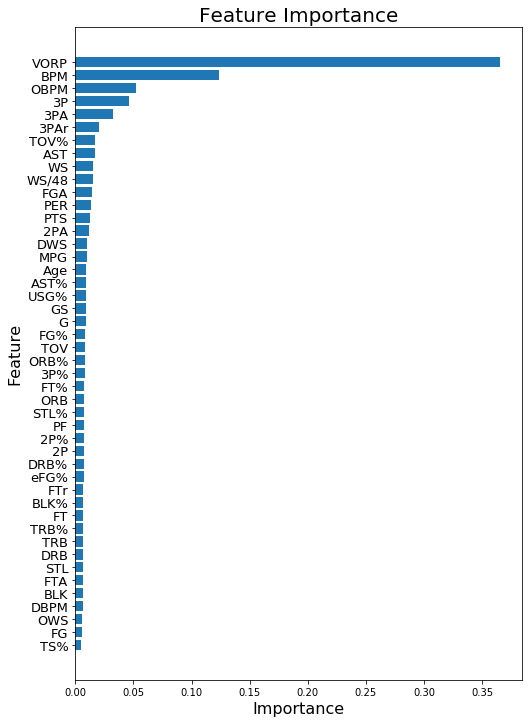

In [60]:
xgb_standard = xgb.XGBRegressor(random_state = 123,objective ='reg:squarederror', gamma = .1,
                               learning_rate = .1, max_depth = 4, min_child_weight = 5, 
                               n_estimators = 100, subsample = .9)
xgb_standard.fit(X_train_scaled_standard,y_train)
# xgb_standard.fit(train_scaled,y_train)
plot_feature_importances(xgb_standard, x, X_train_scaled_standard)
plt.savefig('images/feature_xgb.png', transparent = True)
# evaluate_results(xgb_standard, X_test = X_test_scaled_standard, X_train = X_train_scaled_standard, y_train = y_train, y_test = y_test)

### Discussion

These are quite interesting results! It looks like the most important features are other advanced statistics and 3-point shooting statistics such as 3-pointers made, 3-pointers attempted, and 3-point attempt rate. Here are the definitions for some of the advanced statistics: 

- BPM: a basketball box score-based metric that estimates a basketball player’s contribution to the team when that player is on the court. It is based only on the information in the traditional basketball box score--no play-by-play data or non-traditional box score data (like dunks or deflections) are included.
- OBPM: determined via a regression based formula that purely measures the offensive box plus-minus. 
- VORP: dependent on BPM in that the BPM rate is converted into an estimate of each player's overall contribution to the team, measured vs. what a theoretical "replacement player" would provide, where the "replacement player" is defined as a player on minimum salary or not a normal member of a team's rotation.

Seeing the descriptions of these statistics makes sense as to how they would impact RPM. It also gives insight to the fact that these statistics are purely based off plus-minus and no tracking data or other non-traditional are used. Thus, the feature importance plot gives insight that these traditional advanced statistics are highly correlated with RPM. Furthermore, the next 3 features being related to 3-pointers proves just how impactful the 3-point shot is for offense but also for the gravity it can create by spacing the floor out more and thus leading to greater offensive impact. 

Let's next look at a SHAPley summary plot to help further analysis these results. 


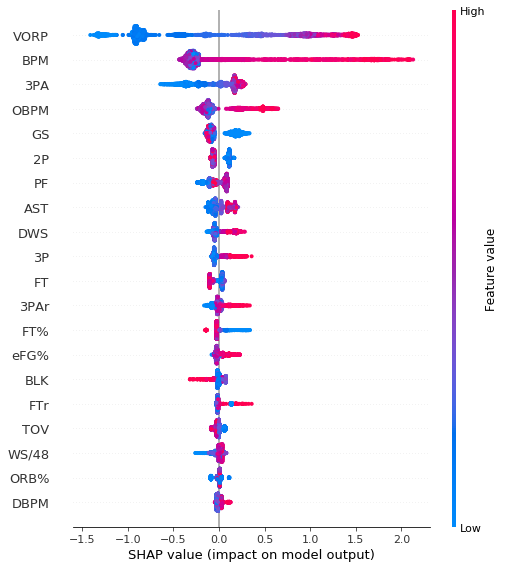

In [39]:
explainer = shap.TreeExplainer(xgb_standard,np.array(x))
shap_values = explainer.shap_values(np.array(x))
fig = plt.figure()
ax = fig.add_subplot()
shap.summary_plot(shap_values, x, show = False)
# ax.spines['bottom'].set_color('white')
# ax.spines['left'].set_color('white')
# ax.tick_params(axis='x', colors='white')
# ax.tick_params(axis='y', colors='white')
# ax.xaxis.label.set_size(15)
# ax.yaxis.label.set_size(15)
# ax.xaxis.label.set_color('white')
# ax.yaxis.label.set_color('white')
# plt.savefig('images/xgb.png', transparent = True)

### Discussion

This plot provides much more insight as to exact what each feature is doing. To give you some background, the color red indicates a higher value for that feature whereas a the color blue indicates a lower value. These higher or lower values are then project upon the horizontal access and that farther you are from the midpoint of 0.0 means the more impact they have in making a higher or lower prediction. 

With that being said, let's analyze the first couple of features. It looks lower and higher values of VORP lead to the most variance in the prediction value of RPM. It also looks like lower values of BPM do not necessarily lead to a lower prediction whereas higher values of BPM do lead to a higher prediction. This looks to also be the case for OBPM. One other interesting insight is lower values of 3-pointers attempted lead to a lower prediction whereas higher values lead to a higher prediction but not as much as lower values of 3PA. Conceptually this is interesting in that it explains how detrimental a low volume 3-point shooter can stagnant an offense as that lowers the spacing a team will have thus making the grind for scoring that much harder. This is even more evident by the 2 pointers made feature where higher values of 2 pointers made leads to a lower prediction. Let's next look at the feature importance for our other top 2 models and see if there's any more insight to be gained that we haven't yet. 

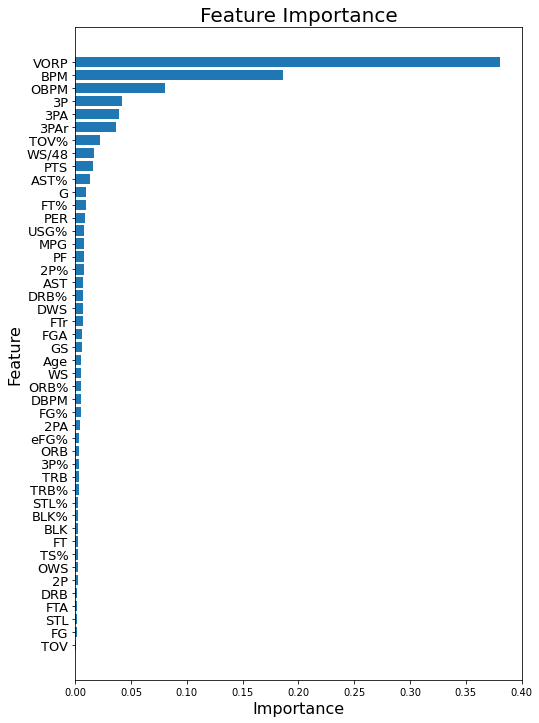

In [49]:
gb = GradientBoostingRegressor(random_state = 123, learning_rate = .1, 
                              loss = 'ls', n_estimators = 100,subsample = .7)
gb.fit(X_train,y_train)
plot_feature_importances(gb, x, X_train)

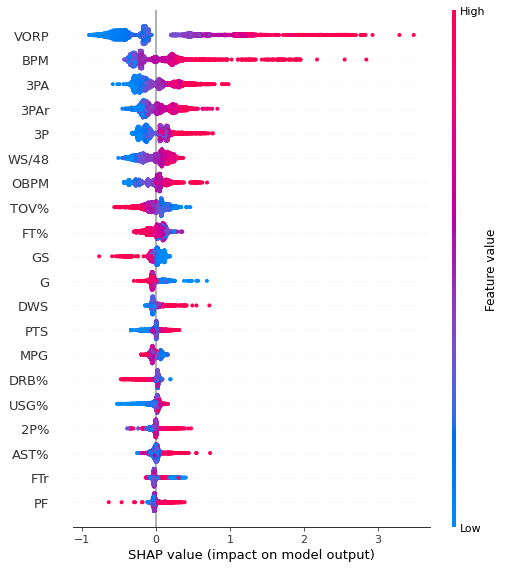

In [59]:
explainer = shap.TreeExplainer(gb,np.array(x))
shap_values = explainer.shap_values(np.array(x))
shap.summary_plot(shap_values, x)

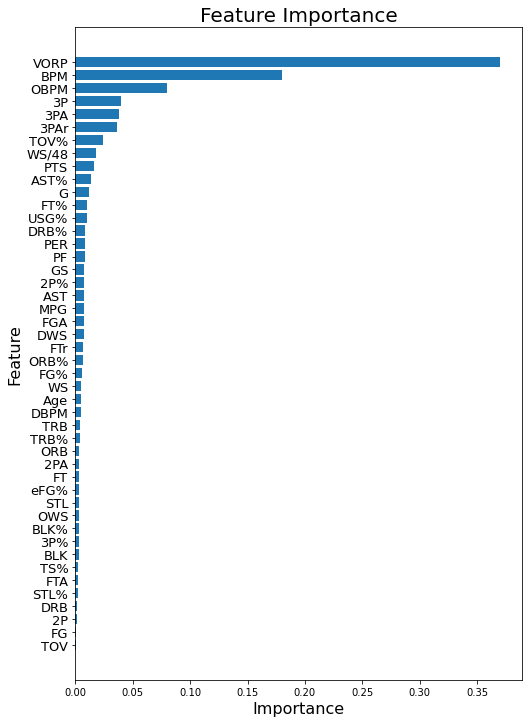

In [51]:
gb_standard = GradientBoostingRegressor(random_state = 123, learning_rate = .1, 
                              loss = 'ls', n_estimators = 120,subsample = .7)
gb_standard.fit(X_train_scaled_standard,y_train)
plot_feature_importances(gb_standard, x, X_train_scaled_standard)

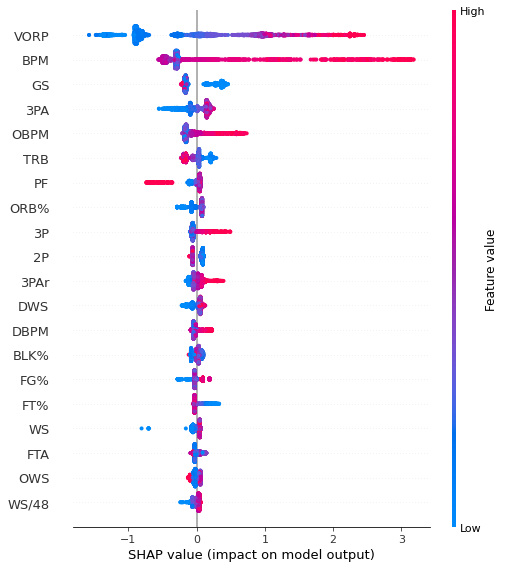

In [52]:
explainer = shap.TreeExplainer(gb_standard,np.array(x))
shap_values = explainer.shap_values(np.array(x))
shap.summary_plot(shap_values, x)

### Discussion

These results are fairly similar in that 3 pointer statistics and traditional advanced statistics still reign supreme. Some other key insights from these two sets of plots that outline feature importance are:

- Turnover Percentage is detrimental to the impact of a player on winning 
- Points are less impactful in predicting RPM which is somewhat contrary to the exploratory data analysis done initially
- Offensive advanced statistics are more important and impactful in predicting RPM which is contrary to what the stat sells itself as which is that they value offense and defense equally 

This in my opinion is the most interesting insight to come out of this analysis. ESPN sells RPM as a statistic that treat offense and defense equally, and while that may be the case the results from these models indicate that offense reigns supreme over defense when it comes to winning. This really helps to confirm my eye-test in that offense in my opinion is endlessly more important than defense and especially if you have players who are highly talented offensively. Constructing a good defense can happen via scrapping players together and good scheme but that is much less the case with offense. Offensive talent reigns supreme and it leads to winning and these models only help to confirm this.

What we will do next is analyze the residuals of our top 3 models and see if there is room for further improvement. 

# Further Improvement


In [264]:
def plot_residuals(model,x,y,test = True):
  if test == True:
    name = 'Testing'
  else:
    name = 'Training'
  preds = model.predict(x)
  if preds.shape[1] == 1:
    preds = preds.flatten()
  resids = y - preds
  plt.scatter(y_test, resids)
  plt.xlabel('True RPM',fontsize = 12)
  plt.ylabel('Residuals', fontsize = 12)
  plt.title(f'Residual Plot of {name} data', fontsize = 14)
  plt.show()

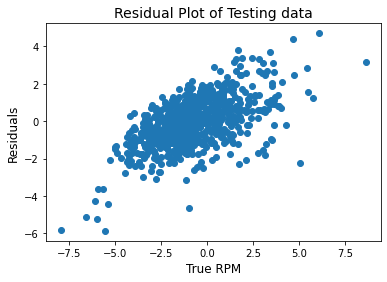

In [245]:
plot_residuals(xgb_standard,X_test_scaled_standard,y_test)

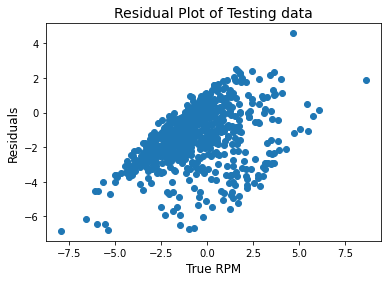

In [246]:
plot_residuals(gb,X_test,y_test)

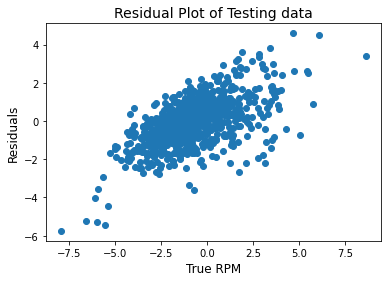

In [247]:
plot_residuals(gb_standard,X_test_scaled_standard,y_test)

These residual plots indicate that our model does worse in predicting outliers than the bulk of the data. Thus, let's see how our model performs when we take out the outliers and implement our top 3 performing models.

In [78]:
df_test = df_tot.copy()

In [79]:
df_test['stdv'] = np.abs(stats.zscore(df_test.RPM))
X = df_test.loc[(df_test.stdv < 3)].copy()
Y = df_test.loc[(df_test.stdv < 3)].RPM
X.drop(columns = ['NAME','TEAM','year','Pos','ORPM','DRPM','RPM','WINS','stdv'], inplace = True)
train, test, y_train2, y_test2 = train_test_split(X,Y, random_state = 123)
standard_scaler = StandardScaler()
train_scaled = standard_scaler.fit_transform(train)
test_scaled = standard_scaler.transform(test)

In [42]:
df_test.loc[(df_test.stdv < 3)].RPM.shape[0] / df_tot.shape[0]

0.991404958677686

In [34]:
xgb_standard_out = xgb.XGBRegressor(random_state = 123,objective ='reg:squarederror', gamma = .1,
                               learning_rate = .1, max_depth = 4, min_child_weight = 5, 
                               n_estimators = 100, subsample = .9)

# xgb_standard.fit(X_train_scaled_standard,y_train)
xgb_standard_out.fit(train_scaled,y_train2)


# plot_feature_importances(xgb_standard, x, X_train_scaled_standard)
evaluate_results(xgb_standard_out, X_test = test_scaled, X_train = train_scaled, y_train = y_train2, y_test = y_test2)

--------------------
Model Results:
Training MSE: 0.7616222478718523
Test MSE: 1.4652837605663132
Training MAE: 0.6689276013845017
Test MAE: 0.9531301644961039
Training R-Squared: 0.8066741217380775
Test R-Squared: 0.6040774018003519
--------------------


In [35]:
gb_out = GradientBoostingRegressor(random_state = 123, learning_rate = .1, 
                              loss = 'ls', n_estimators = 100,subsample = .7)

gb_out.fit(train,y_train2)

evaluate_results(gb_out, X_test = test, X_train = train, y_train = y_train2, y_test = y_test2)

--------------------
Model Results:
Training MSE: 1.0749413346378458
Test MSE: 1.448309982322775
Training MAE: 0.8039421522410207
Test MAE: 0.9488681943960098
Training R-Squared: 0.7271429791086267
Test R-Squared: 0.6086637505774987
--------------------


In [36]:
gb_standard_out = GradientBoostingRegressor(random_state = 123, learning_rate = .1, 
                              loss = 'ls', n_estimators = 120,subsample = .7)
gb_standard_out.fit(train_scaled,y_train2)

evaluate_results(gb_standard_out, X_test = test_scaled, X_train = train_scaled, y_train = y_train2, y_test = y_test2)

--------------------
Model Results:
Training MSE: 1.0097734047756286
Test MSE: 1.431534397726707
Training MAE: 0.7794493271072875
Test MAE: 0.944377993708006
Training R-Squared: 0.7436848373727832
Test R-Squared: 0.6131965470353167
--------------------


These results are better! We should have done this all along but I wanted to wait until the end as I believe the outliers in this scenario are important to address as they indicate the most impactful and least impactful players. What I want to do next is create models without the traditional advanced statistics such as VORP or BPM and see what features are most impactful then!

In [37]:
df_test['stdv'] = np.abs(stats.zscore(df_test.RPM))
X = df_test.loc[(df_test.stdv < 3)].copy()
Y = df_test.loc[(df_test.stdv < 3)].RPM
X.drop(columns = ['NAME','TEAM','year','Pos','ORPM','DRPM','RPM','WINS','WINS','OWS', 'DWS',	'WS',	'WS/48',	'OBPM',	'DBPM',	'BPM'	,'VORP','stdv'], inplace = True)

train, test, y_train2, y_test2 = train_test_split(X,Y, random_state = 123)
standard_scaler = StandardScaler()
train_scaled = standard_scaler.fit_transform(train)
test_scaled = standard_scaler.transform(test)

--------------------
Model Results:
Training MSE: 0.8313695299893501
Test MSE: 1.57285986113154
Training MAE: 0.7024575920760129
Test MAE: 0.980429479689598
Training R-Squared: 0.7889698666307396
Test R-Squared: 0.5750101246038106
--------------------


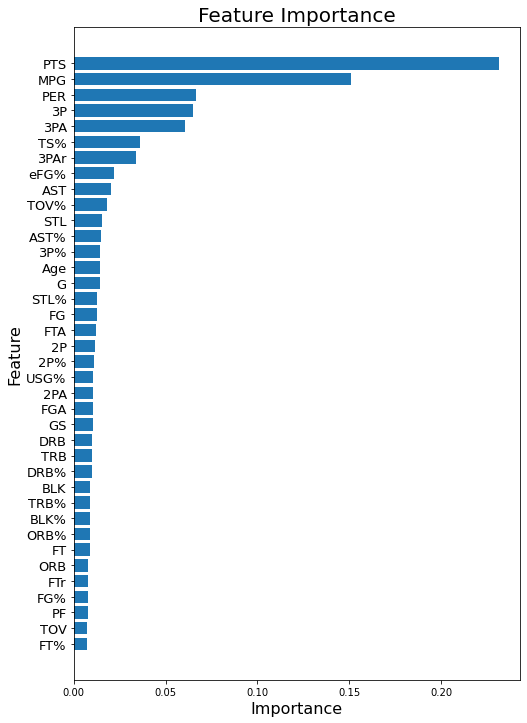

In [38]:
xgb_standard_noadv = xgb.XGBRegressor(random_state = 123,objective ='reg:squarederror', gamma = .1,
                               learning_rate = .1, max_depth = 4, min_child_weight = 5, 
                               n_estimators = 100, subsample = .9)

xgb_standard_noadv.fit(train_scaled,y_train2)


evaluate_results(xgb_standard_noadv, X_test = test_scaled, X_train = train_scaled, y_train = y_train2, y_test = y_test2)
plot_feature_importances(xgb_standard_noadv, X, test_scaled)


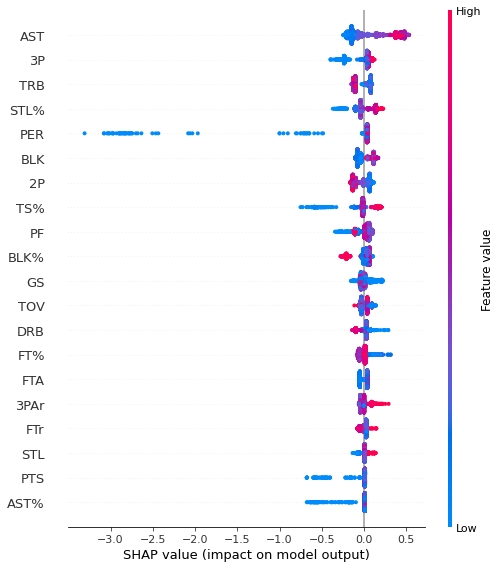

In [44]:
explainer = shap.TreeExplainer(xgb_standard_noadv,np.array(X))
shap_values = explainer.shap_values(np.array(X))
shap.summary_plot(shap_values, X)

--------------------
Model Results:
Training MSE: 1.1426123330100624
Test MSE: 1.625976502785789
Training MAE: 0.8356422397563597
Test MAE: 0.9970521103919125
Training R-Squared: 0.7099657561090025
Test R-Squared: 0.5606579019576919
--------------------


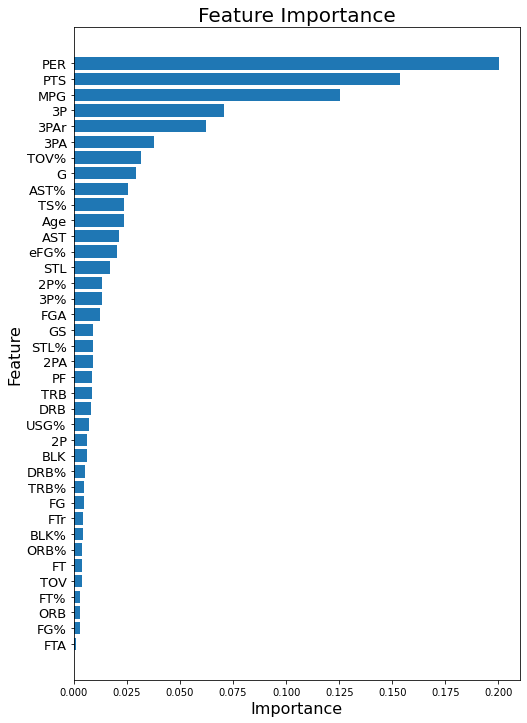

In [39]:
gb_adv = GradientBoostingRegressor(random_state = 123, learning_rate = .1, 
                              loass = 'ls', n_estimators = 100,subsample = .7)

gb_adv.fit(train,y_train2)

evaluate_results(gb_adv, X_test = test, X_train = train, y_train = y_train2, y_test = y_test2)
plot_feature_importances(gb_adv, X, test)


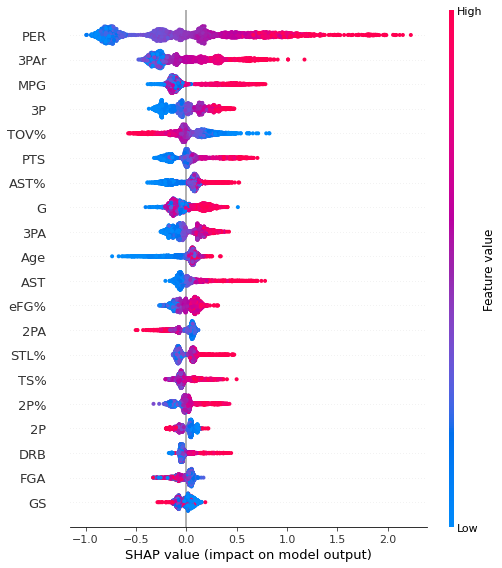

In [47]:
explainer = shap.TreeExplainer(gb_adv,np.array(X))
shap_values = explainer.shap_values(np.array(X))
shap.summary_plot(shap_values, X)

--------------------
Model Results:
Training MSE: 1.0709459953386216
Test MSE: 1.6053056048826777
Training MAE: 0.8093770524888136
Test MAE: 0.99211773212383
Training R-Squared: 0.7281571334103625
Test R-Squared: 0.5662432198498089
--------------------


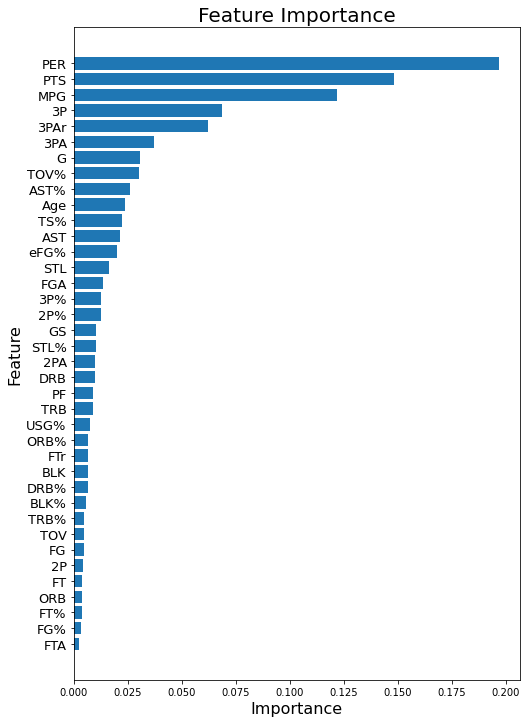

In [40]:
gb_standard_adv = GradientBoostingRegressor(random_state = 123, learning_rate = .1, 
                              loss = 'ls', n_estimators = 120,subsample = .7)
gb_standard_adv.fit(train_scaled,y_train2)

evaluate_results(gb_standard_adv, X_test = test_scaled, X_train = train_scaled, y_train = y_train2, y_test = y_test2)
plot_feature_importances(gb_standard_adv, X, test_scaled)


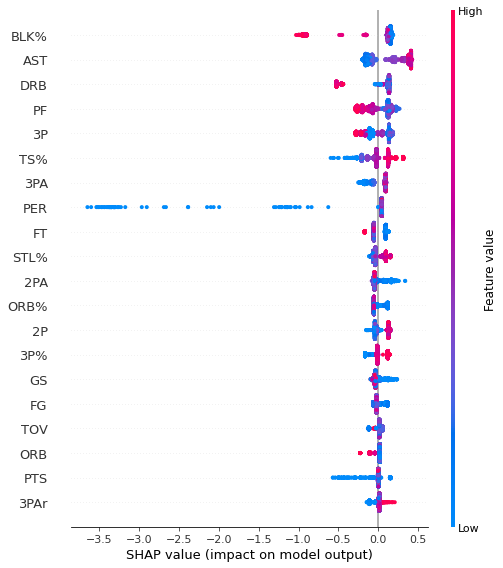

In [45]:
explainer = shap.TreeExplainer(gb_standard_adv,np.array(X))
shap_values = explainer.shap_values(np.array(X))
shap.summary_plot(shap_values, X)

### Discussion

These results are quite interesting in that it looks like some defensive metrics have more impact when we take out the traditional advanced stats and outliers. However, it still looks like offense reigns supreme and the dropout of the outliers and the advanced statistics did lead to poorer results in terms of the R-squared values being lower. This did lead to the MAE and MSE being higher which makes sense due to the fact that the outliers have been removed. These results help to indicate that our best models are either the ones with or without outliers but with the traditional advanced statistics. We now are ready to come to a conclusion as we have developed and analyzed our final models substantially. Thus, let's now implement a function that takes into account a model and the dataset to then return an average result over n iterations. This in turn will give us a better idea of the performance of our model as a random_state is not used.

In [75]:
def average_results(model,x_set,y_set,iterations,scaled,name):
    train_mse = []
    test_mse = []
    train_mae = []
    test_mae = []
    train_r2 = []
    test_r2 = []
    for i in range(iterations):
        X_train, X_test, y_train, y_test = train_test_split(x_set, y_set, test_size = .25)
        if scaled:
            X_train = standard_scaler.fit_transform(X_train)
            X_test = standard_scaler.transform(X_test)
        model.fit(X_train,y_train)
        test_preds = model.predict(X_test)
        train_preds = model.predict(X_train)
        train_mse.append(MSE(y_train,train_preds))
        test_mse.append(MSE(y_test,test_preds))
        train_mae.append(MAE(y_train,train_preds))
        test_mae.append(MAE(y_test,test_preds))
        train_r2.append(r2_score(y_train,train_preds))
        test_r2.append(r2_score(y_test,test_preds))
    print('--------------------')
    print(f'{name} Results:')
    print(f'Training MSE: {np.mean(train_mse)}')
    print(f'Test MSE: {np.mean(test_mse)}')
    print(f'Training MAE: {np.mean(train_mae)}')
    print(f'Test MAE: {np.mean(test_mae)}')
    print(f'Training R-Squared: {np.mean(train_r2)}')
    print(f'Test R-Squared: {np.mean(test_r2)}')
    print('--------------------')


In [76]:
xgb_standard_avg = xgb.XGBRegressor(random_state = 4,objective ='reg:squarederror', gamma = .1,
                               learning_rate = .1, max_depth = 4, min_child_weight = 5, 
                               n_estimators = 100, subsample = .9)
gb_avg = GradientBoostingRegressor(random_state = 123, learning_rate = .1, 
                              loss = 'ls', n_estimators = 100,subsample = .7)
gb_standard_avg = GradientBoostingRegressor(random_state = 123, learning_rate = .1, 
                              loss = 'ls', n_estimators = 120,subsample = .7)

models = [xgb_standard_avg, gb_avg, gb_standard_avg]
names = ['XGBoost using data with StandardScaler', 'Gradient Boosting using data with StandardScaler', 
         'Gradient Boosting using non-scaled data']
scale_vec = [True, False, True]
for ndx,model in enumerate(models):
    average_results(model,x,y,50,scale_vec[ndx],names[ndx])

--------------------
XGBoost using data with StandardScaler Results:
Training MSE: 0.7912778443121951
Test MSE: 1.6403145711502234
Training MAE: 0.6810004402109765
Test MAE: 0.9858151334869971
Training R-Squared: 0.8199220084011059
Test R-Squared: 0.6326824511341806
--------------------
--------------------
Gradient Boosting using data with StandardScaler Results:
Training MSE: 1.0887195729044976
Test MSE: 1.6610078410763314
Training MAE: 0.8138927031161526
Test MAE: 0.9929578101823967
Training R-Squared: 0.7522316672212842
Test R-Squared: 0.6271019355576637
--------------------
--------------------
Gradient Boosting using non-scaled data Results:
Training MSE: 1.0129092899685594
Test MSE: 1.6633863301220253
Training MAE: 0.7845139346023395
Test MAE: 0.9977835393587171
Training R-Squared: 0.7697534622289993
Test R-Squared: 0.6260599567247352
--------------------



# Conclusion

This project helped to really enhance and confirm some of my basketball understanding but more so my machine learning understanding. It pushed me to find different ways to improve a model via the introduction of new variables, removing outliers, hyperparameter tuning, and implementation of every conceivable regression model. The interesting insight gained from the analysis of these models is that offense does indeed reign supreme as it was often the case where the more influential and important parameters were related to offense. Furthermore, the prevalence of the 3-point shot is evident via the results of these models in that it helps confirm how it leads to more of an impact on the court. This is due to just how much gravity a 3-point shot creates in that it leads to just much easier offense when the 3-point shot is respected by the other team. Lastly, the analysis of these models indicate that the traditional advanced statistics such as BPM and VORP have a significant impact on RPM and thus the impact a player has on the court. 

It was very cool to see something I am very passionate and knowledgeable about in basketball be paired with something I am slowly gaining knowledge about in machine learning. With that being said, there is still so much I could have done with this project and basketball in general. That includes:

- Using RPM from past years to predict current RPM
- Introducing non-traditional statistics (particularly defensive stats to see if it improves results
- Focusing on ORPM and the features that affect it the most
- Looking into how different team statistics affect winning percentage over the years as the sport has changed
- More feature selection via boruta as I pursued this route initially and it did not lead to better results so I pivoted in another direction
- Drop dependent features such as 3PA or 3P and find a way to maintain comparable results as the performance went down when I attempted this
- Try more neural network tuning techniques and architectures as the results were worse after many iterations and thus I decided to not pursue them anymore

As you can see there is still a lot to do! And I'm slowly starting to learn that will always be the case in this world. There is always room for improvement and that will never not be the case as myself and the community learn more about this interesting realm that is Machine Learning. This project helped to improve my skills as a data scientist in that there was no answer or guidance to follow from classes or online. That pushed me to think hard and outside of the box in how I want to preprocess the data but also how I want to model the data. As you can tell, this was a worthwhile experience and I'd like to thank the Flatiron Community and my instructor Jeff Herman for getting me to where I am now. 

